# <span style='font-family:"Times New Roman"'> <span styel=''>**ENDOMETRIAL CANCER ANALYSIS**

*Emile Cohen*
    
*July 2020*

**Goal**: In this notebook, we want to understand what makes Endometrial Cancer a textbook case for the patterns we saw, and what are the major subcohorts that drive the signal.

---

In [9]:
%run -i '../../../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec
import pickle

data_path = '../../../../../data/'
data_wgd = data_path + 'impact-facets-tp53/processed/wgd/'
data_no_wgd = data_path + 'impact-facets-tp53/processed/no_wgd/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

In [11]:
# Export to HTML
!jupyter nbconvert --to html endometrial_cancer.ipynb

[NbConvertApp] Converting notebook endometrial_cancer.ipynb to html
[NbConvertApp] Writing 4358704 bytes to endometrial_cancer.html


## Interesting functions

In [6]:
from functools import reduce

def get_hotspots(df: pd.DataFrame, Sample_Type: str, group: list = None, group_type:str = None):
    data = df[df['Sample_Type'] == Sample_Type]
    
    if group and group_type:
        data = data[data[group_type].isin(group)]

    data_1 = get_groupby(data,'tp53_spot_1', 'count'); data_2 = get_groupby(data,'tp53_spot_2', 'count'); data_3 = get_groupby(data,'tp53_spot_3', 'count') ; data_4 = get_groupby(data,'tp53_spot_4', 'count') ; data_5 = get_groupby(data,'tp53_spot_5', 'count') 
    series_data = [data_1,data_2,data_3,data_4,data_5]

    df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True,
                                                how='outer'), series_data).fillna(0)

    df_merged.columns = ['count_1', 'count_2', 'count_3', 'count_4', 'count_5']
    df_merged['total'] = df_merged.sum(axis=1)
    df_merged = df_merged.sort_values(by='total', ascending=False)

    df_merged = df_merged.drop('nan')
    
    return df_merged

def get_hotspot_frac(df: pd.DataFrame, group_type:str = None, group: list = None, nb = 10):
    if group_type and group:
        df = df[df[group_type].isin(group)]
    result = [['spot', '#', 'frac']]
    for spot in get_groupby(df, 'tp53_spot_1', 'count').sort_values(by='count', ascending=False).head(nb).index.tolist():
        result.append([spot,df[df['tp53_spot_1'] == spot].frac_genome_altered.shape[0], df[df['tp53_spot_1'] == spot].frac_genome_altered.median()])

    return pd.DataFrame(result)


def boxplot_sampletype(df: pd.DataFrame, group:str, palette, order, metrics: str, figsize= (10,3), title: str = '', title_font: int=12, xlim=[0,1]):
    fig=plt.figure(figsize=figsize)
    ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)

    sns.boxplot(y=metrics, x=group,data=df,ax=ax, dodge=False,order=order, palette=palette).set_title(title, weight='bold', fontsize=title_font)
    
    groupby_ = get_groupby(df,group, 'count')
    
    labels = []
    for element in order:
        labels.append(element + '\n('+ str(groupby_.loc[element].values[0])+')')
    
    
    
    ax.set_xticklabels(labels)
    style(ax)
    ax.set_ylim(xlim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return fig, ax


# Let's give a look at medians and statistics

def get_statistics(df: pd.DataFrame, group:str, metrics: str, group_list: list):
    group_1 = df[df[group] == group_list[0]][metrics]
    group_2 = df[df[group] == group_list[1]][metrics]

    median_1 = group_1.median()
    median_2 = group_2.median()

    statistic, p_value = ranksums(group_1.dropna().values,group_2.dropna().values)
    
    results = [['', 'size', metrics],
               [group_list[0], group_1.shape[0], median_1],
               [group_list[1], group_2.shape[0], median_2],
               ['', 'Statistics', 'p-value'],
               ['', statistic, p_value]]


    return pd.DataFrame(results)


def get_major_codrivers(master: pd.DataFrame, maf: pd.DataFrame, head:int = 10, tp53=False):
    samples = master.Tumor_Id.tolist()
    if tp53:
        maf_filtered = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['driver'] == True]
    else:
        maf_filtered = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['driver'] == True][maf['Hugo_Symbol'] != 'TP53']
    h = pd.DataFrame(maf_filtered[['Hugo_Symbol']].groupby(['Hugo_Symbol']).size())
    h.columns = ['count']
    h = h.sort_values(by='count', ascending=False).head(head)
    
    return(h)


def create_co_drivers_table(master: pd.DataFrame, group_type:str,  group_1: str, group_2: str):
    master_group_1 = master[master[group_type] == group_1]
    co_drivers_group_1 = get_major_codrivers(master=master_group_1,
                        maf=maf_cohort_nowgd,
                       head=100)
    co_drivers_group_1['proportion_1'] = co_drivers_group_1.apply(lambda x: 100* round(x['count'] / co_drivers_group_1.sum().values[0], 4), axis=1)
    
    master_group_2 = master[master[group_type] == group_2]
    co_drivers_group_2 = get_major_codrivers(master=master_group_2,
                        maf=maf_cohort_nowgd,
                       head=100)
    co_drivers_group_2['proportion_2'] = co_drivers_group_2.apply(lambda x: 100* round(x['count'] / co_drivers_group_2.sum().values[0], 4), axis=1)
    
    co_drivers_groups = pd.merge(co_drivers_group_1, co_drivers_group_2, on='Hugo_Symbol')
    co_drivers_groups['proportion_1'] = - co_drivers_groups['proportion_1']
    
    return co_drivers_groups

## Master Definition and Filtering

In [7]:
cancer = 'Endometrial Cancer'

In [8]:
master_no_wgd = non_wgd_load_and_cut(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')
master_wgd = pd.read_pickle(data_path + 'impact-facets-tp53/processed/wgd/master_wgd.pkl')

master_no_wgd_cancer = master_no_wgd[master_no_wgd['Cancer_Type'] == cancer]
master_wgd_cancer = master_wgd[master_wgd['Cancer_Type'] == cancer]

maf_cohort_nowgd = pd.read_csv(data_path + 'impact-facets-tp53/processed/no_wgd/maf_cohort_nowgd.txt', sep='\t').drop('Unnamed: 0', axis=1)
maf_cohort_wgd = pd.read_csv(data_path + 'impact-facets-tp53/processed/wgd/maf_cohort_wgd.txt', sep='\t').drop('Unnamed: 0', axis=1)

# What makes Endometrial Cancer a TextBook Case?

## WGD Proportion

Breast Cancer is the biggest cancer in our cohort. Breast Cancer has a slightly low proportion of WGD - around 30%
<img src="wgd_proportion.png" width=700 length=700>

## Cancer Panel

* Endometrial Cancer is one of the most represented cancer in MSK-Impact Cohort.
* Highly enriched in LOSS Samples: 0_HETLOSS and >=1_LOSS account for more than 90% of the cancer cohort
* Depleted in >=1_cnLOH, 0_HETLOSS

<img src="endometrial_header.png" width=700 length=700>
<img src="endometrial_panel.png" width=1000 length=700>

## Genome Instability

Endometrial Cancer shows a significant difference in Genome Instability between TP53 Mono-Allelic and Bi-Allelic subgroups - and has a lot of samples in both groups.
<img src="gi_pancancer_frac_no_wgd.png" width=1000 length=600>

In the TP53 subgroup Pan Cancer plot that follows, we can see 2 important signals:
* *1_WILD_TYPE* and *0_HETLOSS* GI are very low compared to other subgroups
* Bi Allelic Subgroups - *>=1_LOSS* and *>=1_cnLOH* - have higher GI  than other subgroups and the difference is significant




<img src="pancancer_gi_sub.png" width=1000 length=600>



# WGD Part

## Subgroup Proportion

In the following cells are the proportions of different groupo levels: on the right Primary samples, on the left Metastatic samples.

<img src="pre_prop.png" width=1000 length=600>
<img src="pre_legend.png" width=200 length=200>

<img src="mut_loh_prop.png" width=1000 length=600>
<img src="mut_loh_legend.png" width=200 length=200>

## Very High Genome Instability

In WGD cohort, Genome Instability median is above 70% for all cancer types.

We still see difference between TP53 bi-allelic and mono-allelic states but those are not very significant:
<img src="pancancer_gi_wgd.png" width=1000 length=600>

# No WGD Part - Cancer Investigation
In this section, our goal is to find subcohorts that lead the signals observed. Here are the different subcohort we will create:
* Hotspot Analysis: splitting on 273 / 248 / 175 / Missense / Truncated / In Frame
* CCF Analysis
* SNV/INDEL Analysis

## Hotspot Analysis
In this section, we cut our cohort to only keep samples with exactly one TP53 mutation, for simplicity.

In [12]:
master_hotspot = master_no_wgd_cancer[master_no_wgd_cancer['tp53_count'] == 1]

In [13]:
get_hotspot_frac(df=master_hotspot,
                group_type=None,
                group=None)

,0,1,2
0,spot,#,frac
1,273,20,0.2905
2,248,16,0.291
3,245,10,0.3785
4,nan,9,0.301
5,175,9,0.252
6,220,7,0.279
7,241,6,0.297
8,278,6,0.2235
9,213,5,0.065


### Entire Cohort

,count
tp53_vc_group_1,
missense,77
truncated,38
hotspot,22
273,20
248,16
175,9
in_frame,6


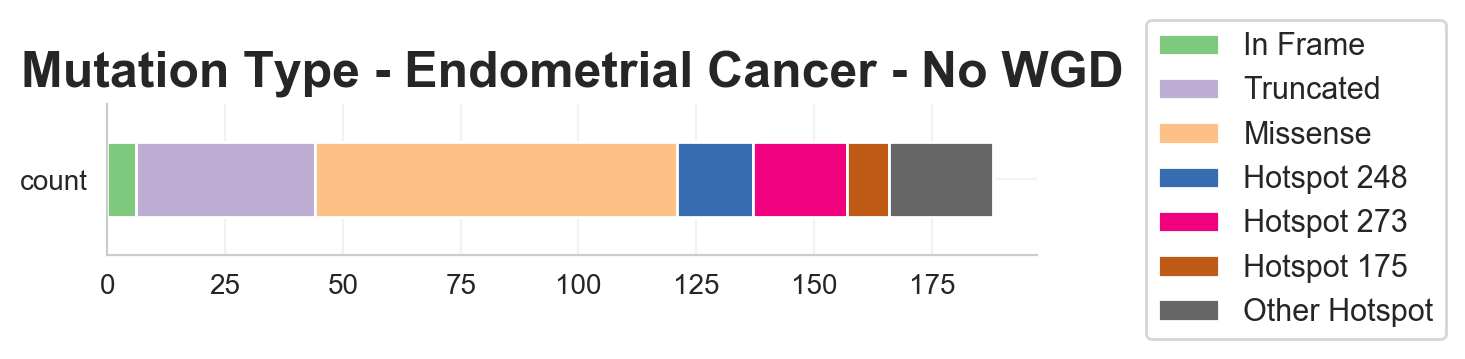

In [14]:
h = get_groupby(master_hotspot,'tp53_vc_group_1', 'count').sort_values(by='count', ascending=False)
display(h)

h = h.T
h = h[mutation_list]
fig = plt.figure(figsize=(6,1))
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax, colormap="Accent")
ax.legend(['In Frame', 'Truncated', 'Missense', 'Hotspot 248','Hotspot 273','Hotspot 175', 'Other Hotspot'],loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=11)
ax.set_title('Mutation Type - {} - No WGD'.format(cancer), weight='bold', fontsize=18)

plt.show()

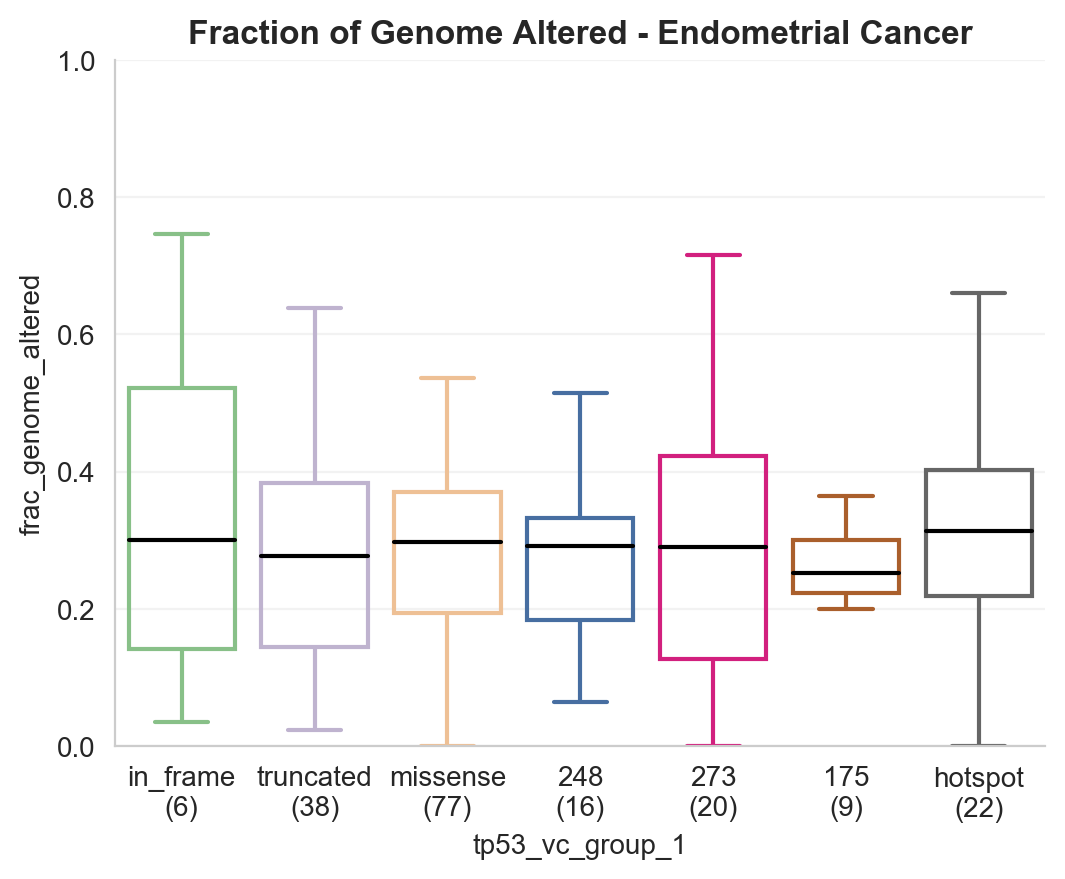

In [15]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='tp53_vc_group_1',
                  palette=mutation_palette,
                  order=mutation_list,
                  metrics='frac_genome_altered',
                  figsize=(6,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

### TP53 Residual Subgroups

In [16]:
print('Number of Bi Allelic samples (with 1 mut): ' + str(master_hotspot[master_hotspot['tp53_res_group'] == 'no_tp53_res'].shape[0]))
print('')
print('Number of  TP53 Residual samples (with 1 mut): ' + str(master_hotspot[master_hotspot['tp53_res_group'] == 'tp53_res'].shape[0]))



Number of Bi Allelic samples (with 1 mut): 147

Number of  TP53 Residual samples (with 1 mut): 35


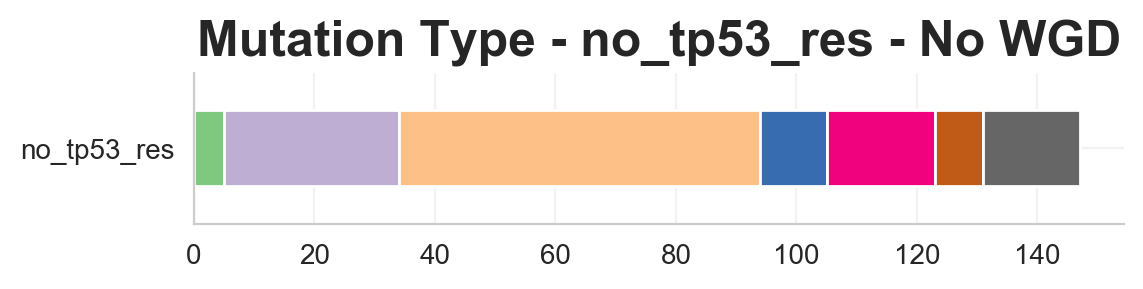

,no_tp53_res
tp53_vc_group_1,
missense,60
truncated,29
273,18
hotspot,16
248,11
175,8
in_frame,5


In [17]:
total_df = []
for group in ['no_tp53_res']:
    h = get_groupby(master_hotspot[master_hotspot['tp53_res_group'] == group], 'tp53_vc_group_1', group).sort_values(by=group, ascending=False)
    total_df.append(h)
    
    h = h.T
    h = h[mutation_list]
    fig = plt.figure(figsize=(6,1))
    ax = plt.subplot()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax, colormap="Accent")
    if group == 'tp53_res':
        ax.legend(['In Frame', 'Truncated', 'Missense', 'Hotspot 248','Hotspot 273','Hotspot 175', 'Other Hotspot'],loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=11)
    else: ax.get_legend().remove()
    ax.set_title('Mutation Type - {} - No WGD'.format(group), weight='bold', fontsize=18)

    plt.show()

display_side_by_side(total_df[0])

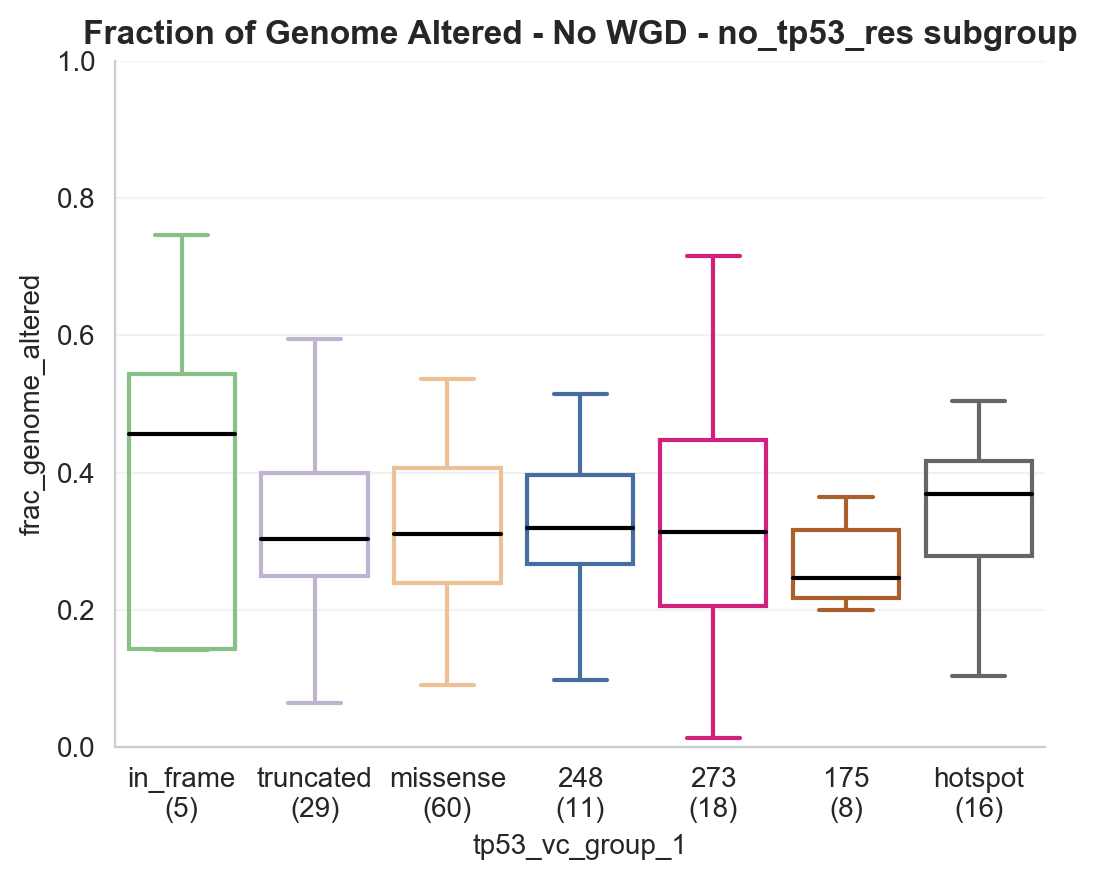

In [18]:
for group in ['no_tp53_res']:
    master_wt = master_hotspot[master_hotspot['tp53_res_group'] == group]

    fig, ax = boxplot_sampletype(df=master_wt,
                      group='tp53_vc_group_1',
                      palette=mutation_palette,
                      order=mutation_list,
                      metrics='frac_genome_altered',
                      figsize=(6,10),
                      title='Fraction of Genome Altered - No WGD - {} subgroup'.format(group),
                      xlim=[0,1])
    plt.show()

## SNV / INDEL Analysis
In this section we compare SNV and INDEL mutations. As in the previous section, we cut the cohort to keep only samples with exactly 1 tp53 mutation.

###  # of Drivers / SNV Drivers / INDEL Drivers 

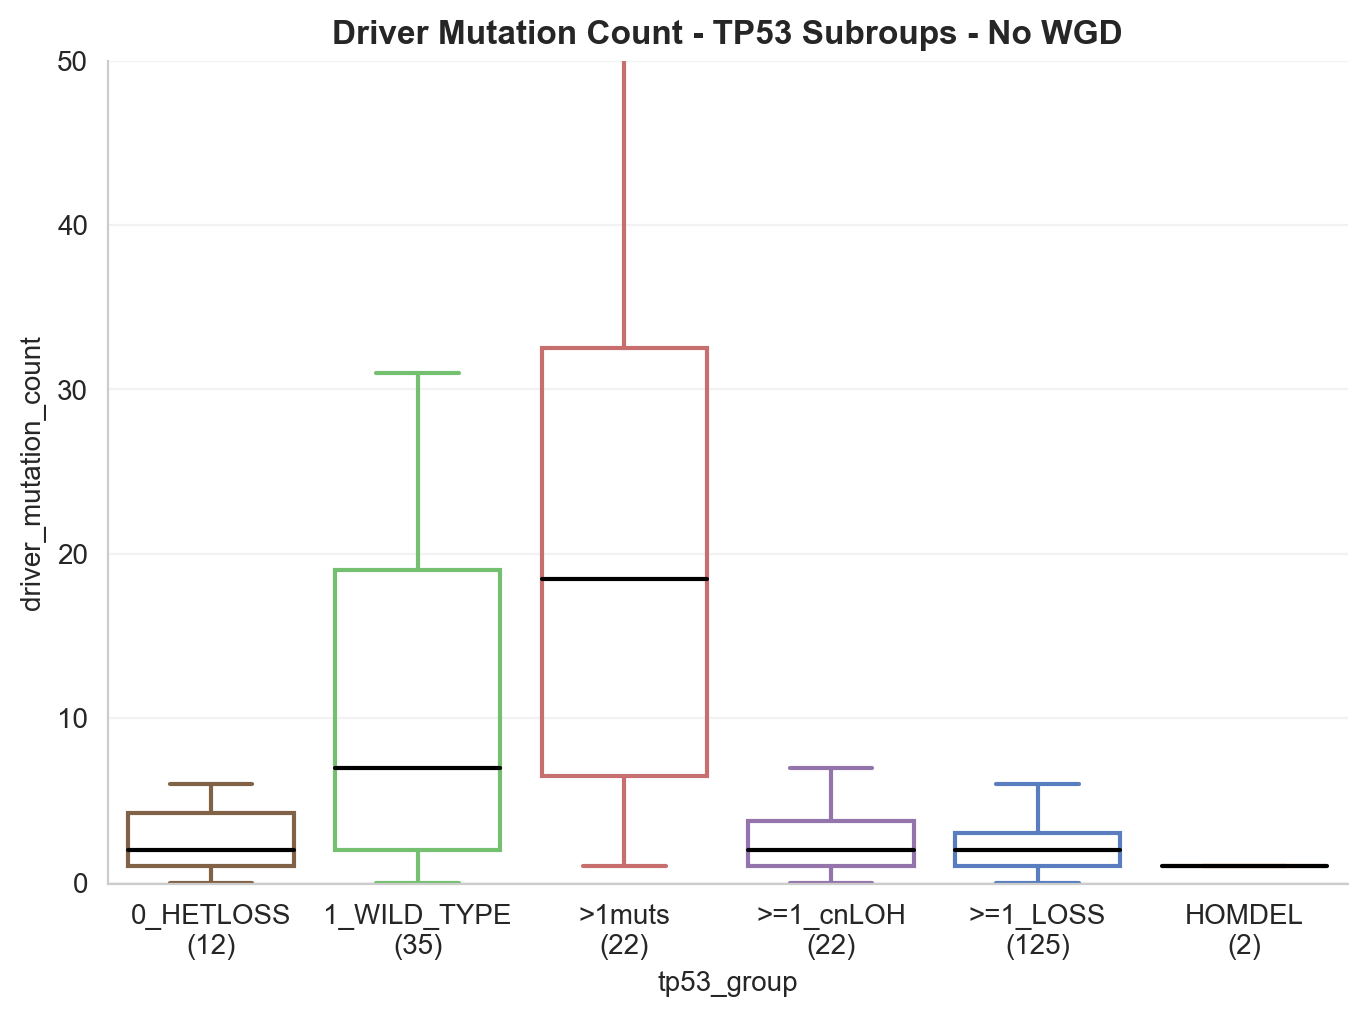

,0,1,2
0,,size,driver_mutation_count
1,1_WILD_TYPE,35,7
2,0_HETLOSS,12,2
3,,Statistics,p-value
4,,2.40315,0.0162543
,0,1,2
0,,size,driver_mutation_count
1,1_WILD_TYPE,35,7
2,>=1_LOSS,125,2
3,,Statistics,p-value


In [19]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='driver_mutation_count',
                  figsize=(8,12),
                  title='Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,50])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

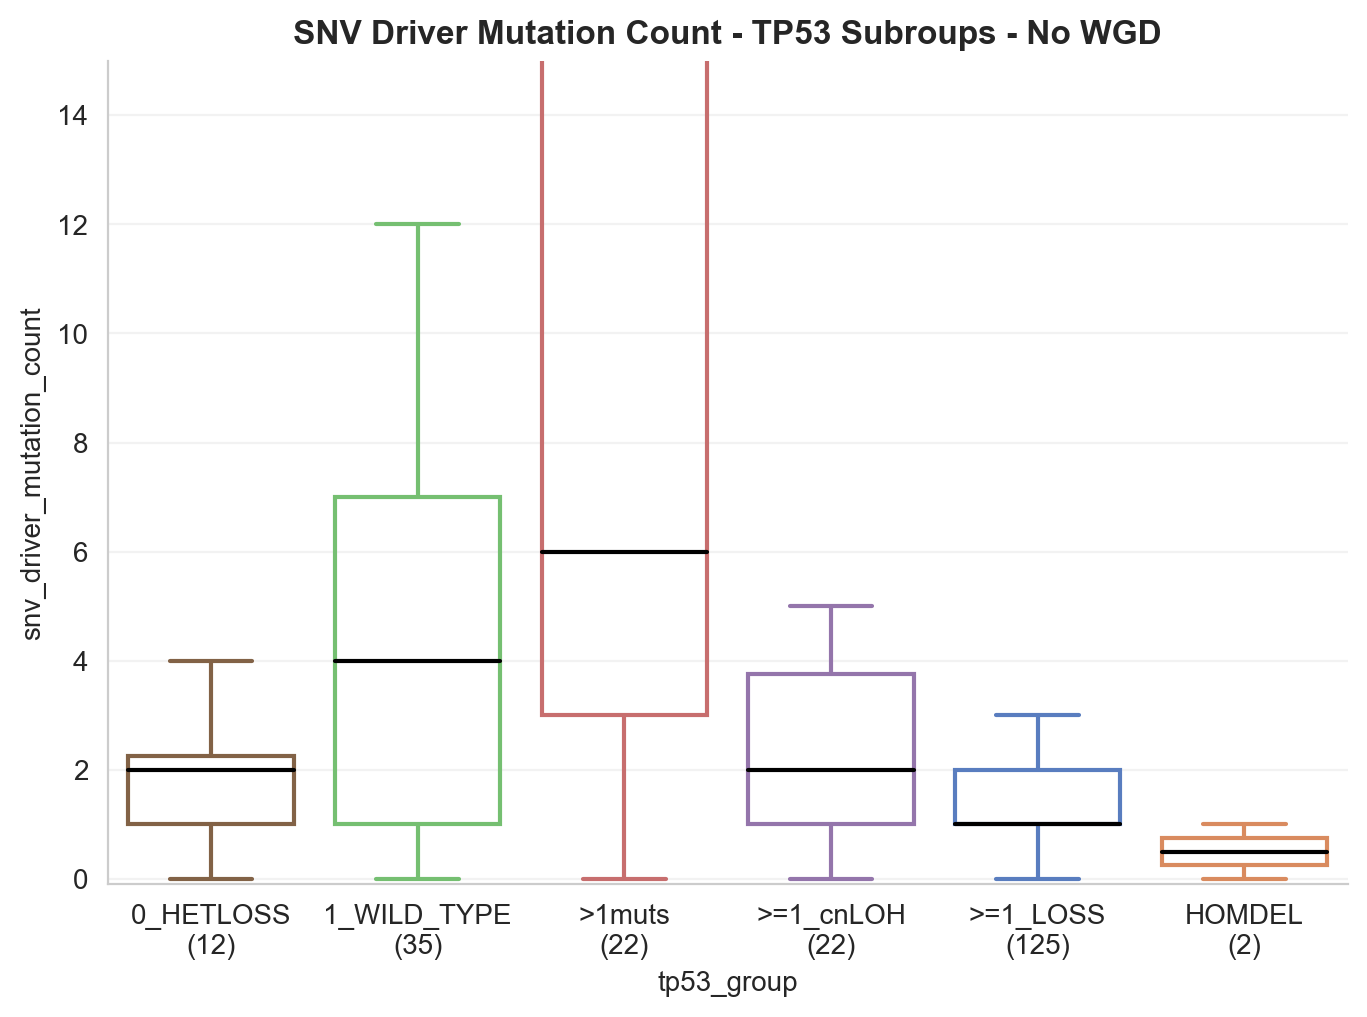

,0,1,2
0,,size,snv_driver_mutation_count
1,1_WILD_TYPE,35,4
2,0_HETLOSS,12,2
3,,Statistics,p-value
4,,2.19578,0.028108
,0,1,2
0,,size,snv_driver_mutation_count
1,1_WILD_TYPE,35,4
2,>=1_LOSS,125,1
3,,Statistics,p-value


In [20]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='snv_driver_mutation_count',
                  figsize=(8,12),
                  title='SNV Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,15])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

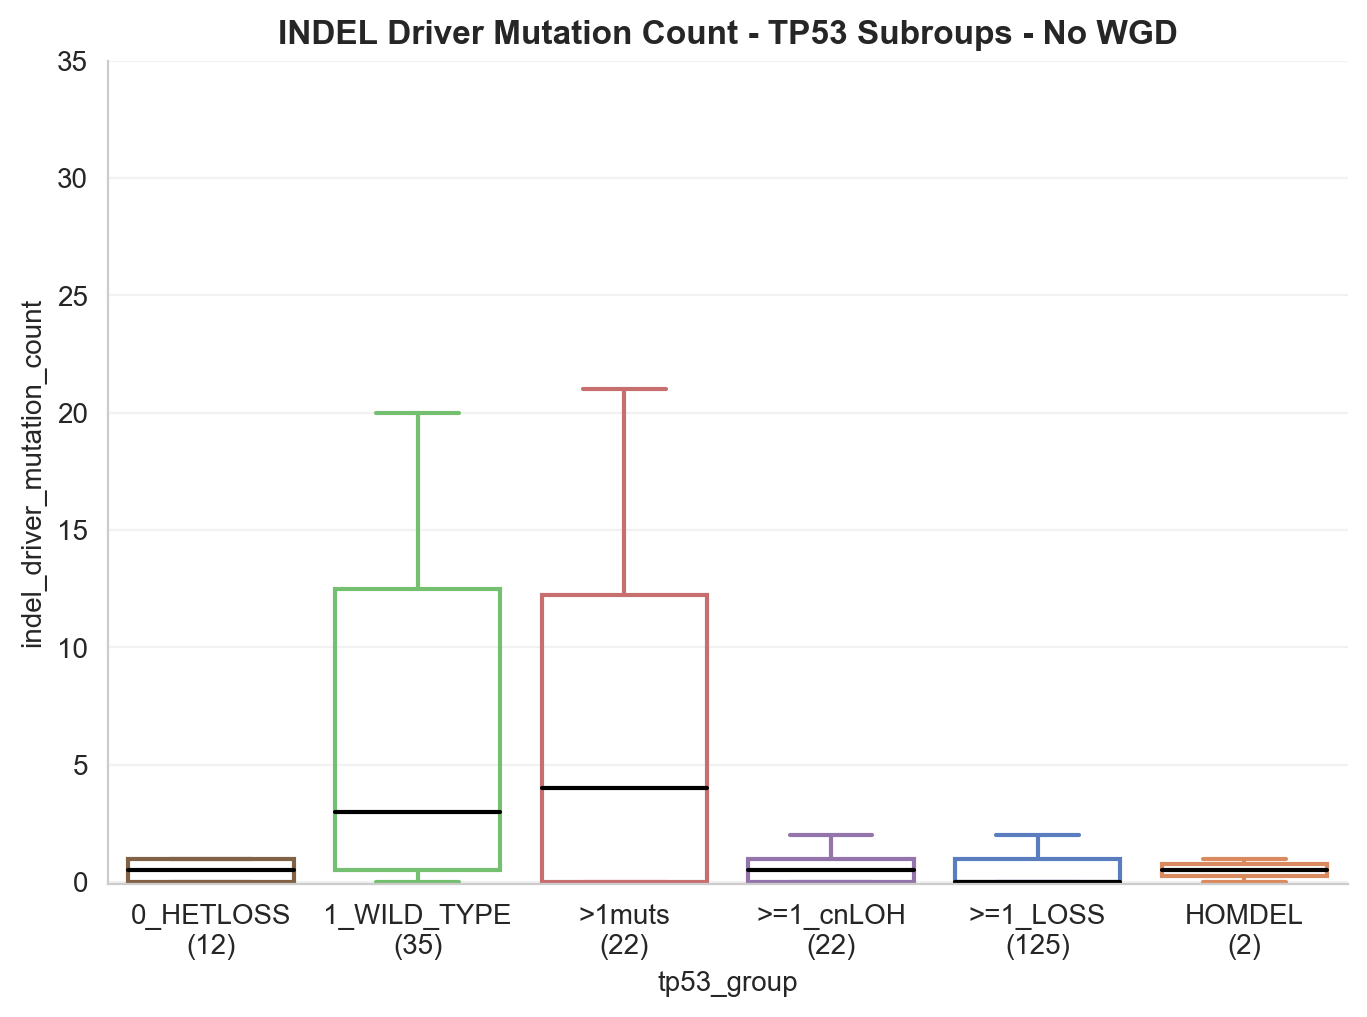

,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,35,3
2,0_HETLOSS,12,0.5
3,,Statistics,p-value
4,,2.48855,0.0128267
,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,35,3
2,>=1_LOSS,125,0
3,,Statistics,p-value


In [21]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='indel_driver_mutation_count',
                  figsize=(8,12),
                  title='INDEL Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,35])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

### Genome Instability 
The idea here is to see if we have differences in Fraction of Genome Altered if we cut our Cancer cohort on the number of drivers per sample. 

Do we have more instability with more INDEL Driver Mutations within the same subgroup?

#### 1_WILD_TYPE Subgroup

In [22]:
master_no_wgd_cancer_wt = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '1_WILD_TYPE']

thr=6

def get_driver_groups(x):
    if x.driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_wt['co_driver_group'] = master_no_wgd_cancer_wt.apply(get_driver_groups, axis=1)

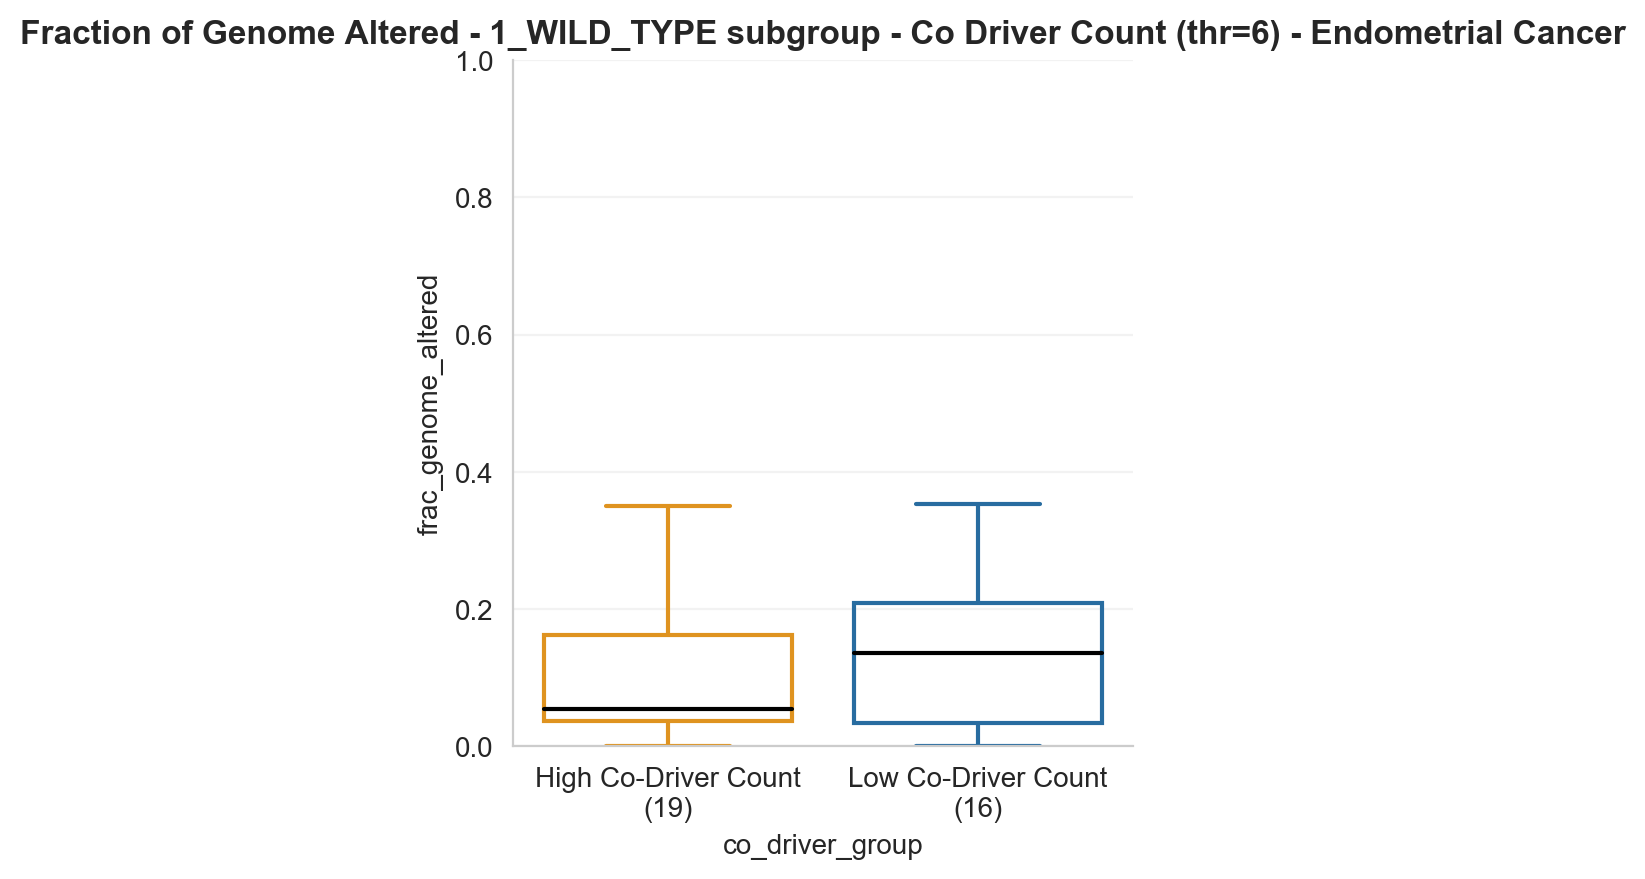

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,19,0.054
2,Low Co-Driver Count,16,0.1355
3,,Statistics,p-value
4,,-0.711936,0.476504


In [23]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_wt,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 1_WILD_TYPE subgroup - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_wt,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

In [24]:
def plot_density(df: pd.DataFrame, xlabel='', ylabel='', title='',clip = (0,3), group = None,  figsize=(5,5)):
    sns.set_style("whitegrid", {'grid.color': '1.'})
    fig, ax = plt.subplots(figsize=figsize)
    
    
    data =df['tp53_ccf_1']
    ax = sns.distplot(data,kde_kws={'clip': clip, "shade": True}, hist=False)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title('TP53 CCF for 1_WT in Non WGD Samples'  + title + ' (' + str(len(data)) + ')', weight = 'bold')
    
    mean=round(data.mean(),2) ; median=round(data.median(),2)
    string = 'Mean: '+ str(mean) +'\nMedian: ' + str(median)
    ax.axvline(mean, color='g', linestyle='-', label='Mean: '+ str(mean))
    ax.axvline(median, color='b', linestyle='-', label='Median: ' + str(median))
    ax.legend()
    #ax.set_xlim([0,1])
    
    plt.show()

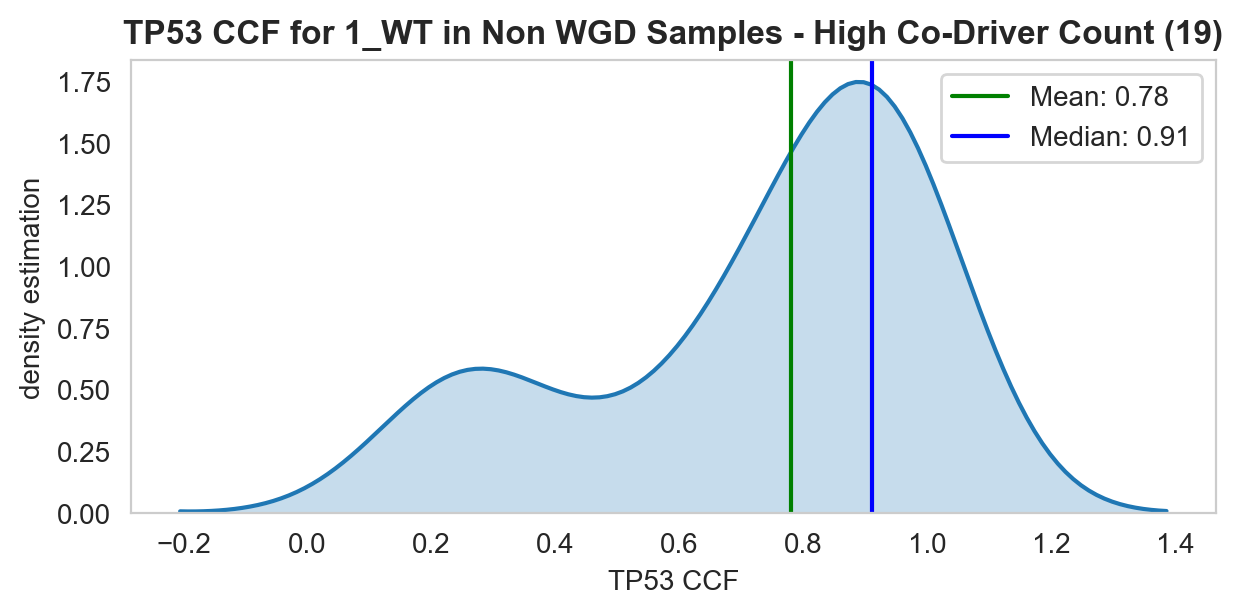

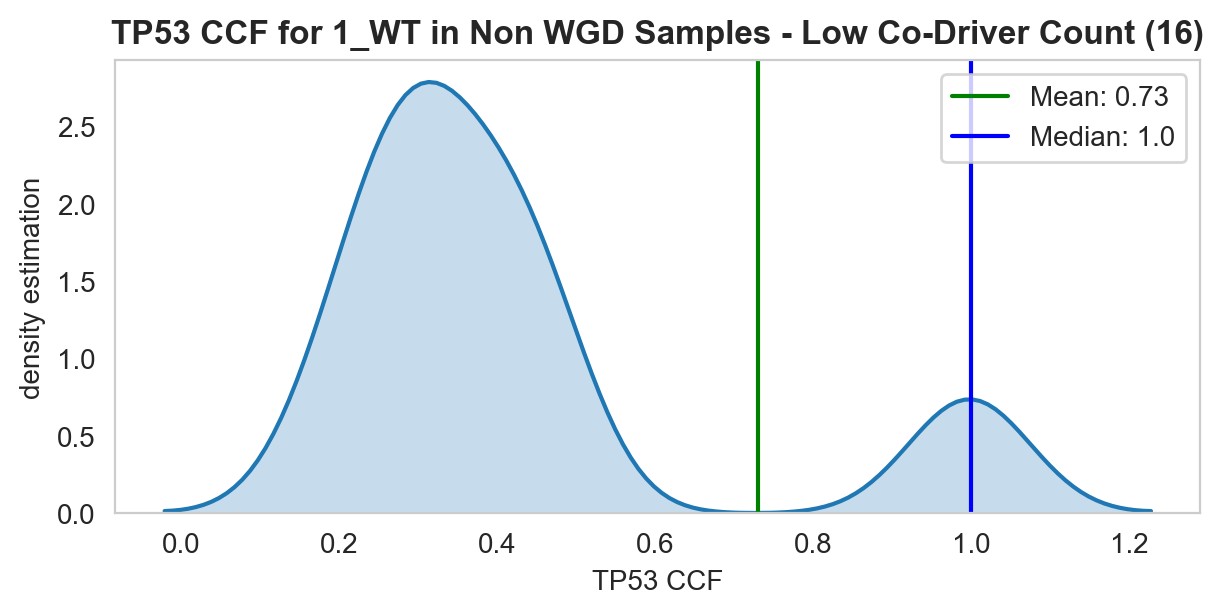

In [25]:
master_high_count = master_no_wgd_cancer_wt[master_no_wgd_cancer_wt['co_driver_group'] == 'High Co-Driver Count']
master_low_count = master_no_wgd_cancer_wt[master_no_wgd_cancer_wt['co_driver_group'] == 'Low Co-Driver Count']

plot_density(df=master_high_count,
             xlabel='TP53 CCF', 
             ylabel='density estimation',
             title=' - High Co-Driver Count',
             clip = (0,1), 
             group = None,  figsize=(7,3))
plt.show()

plot_density(df=master_low_count,
             xlabel='TP53 CCF', 
             ylabel='density estimation',
             title=' - Low Co-Driver Count',
             clip = (0,1), 
             group = None,  figsize=(7,3))

plt.show()

So we see that samples with less co-drivers have a higher Genome Instability

#### 0_HETLOSS

In [26]:
master_no_wgd_cancer_het = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '0_HETLOSS']

thr=0

def get_driver_groups(x):
    if x.indel_driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.indel_driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_het['co_driver_group'] = master_no_wgd_cancer_het.apply(get_driver_groups, axis=1)

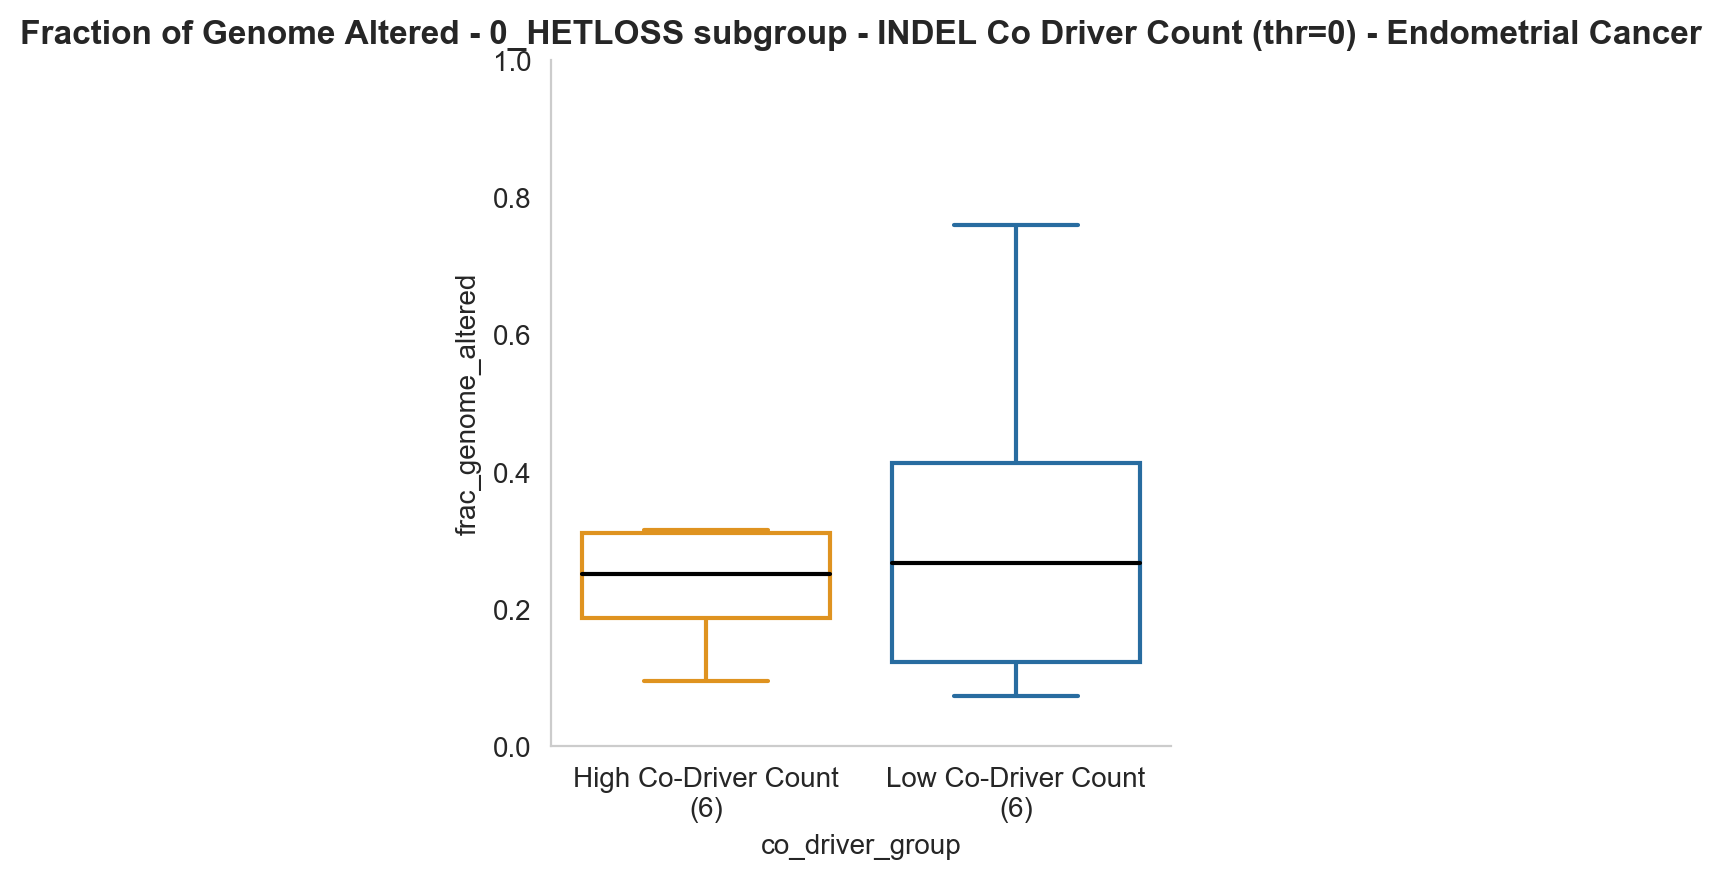

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,6,0.2515
2,Low Co-Driver Count,6,0.2665
3,,Statistics,p-value
4,,-0.160128,0.87278


In [27]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_het,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 0_HETLOSS subgroup - INDEL Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_het,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

### Low CCF Analysis

In [28]:
thr_ccf_1 = 0.9

def ccf_subgroup(x):
    if x.tp53_ccf_1 <= thr_ccf_1: return 'low'
    elif x.tp53_ccf_1 > thr_ccf_1: return 'high'

master_no_wgd_cancer['ccf_group'] = master_no_wgd_cancer.apply(ccf_subgroup, axis=1)
get_groupby(master_no_wgd_cancer, 'ccf_group', 'count')

,count
ccf_group,
high,153
low,56


In [29]:
pd.DataFrame(master_no_wgd_cancer[['ccf_group', 'tp53_group']].groupby([ 'tp53_group', 'ccf_group']).size())

0
tp53_group  ccf_group     
1_WILD_TYPE high        19
            low         15
>1muts      high         9
            low         12
>=1_LOSS    high       105
            low         20
>=1_cnLOH   high        16
            low          6
HOMDEL      low          1

In [30]:
master_no_wgd_cancer_low = master_no_wgd_cancer[(master_no_wgd_cancer['ccf_group'] == 'low') | (master_no_wgd_cancer['tp53_count'] == 0)]
get_groupby(master_no_wgd_cancer_low, 'tp53_group', 'count')

,count
tp53_group,
0_HETLOSS,12
1_WILD_TYPE,15
>1muts,12
>=1_LOSS,20
>=1_cnLOH,6
HOMDEL,2


#### # of Drivers 

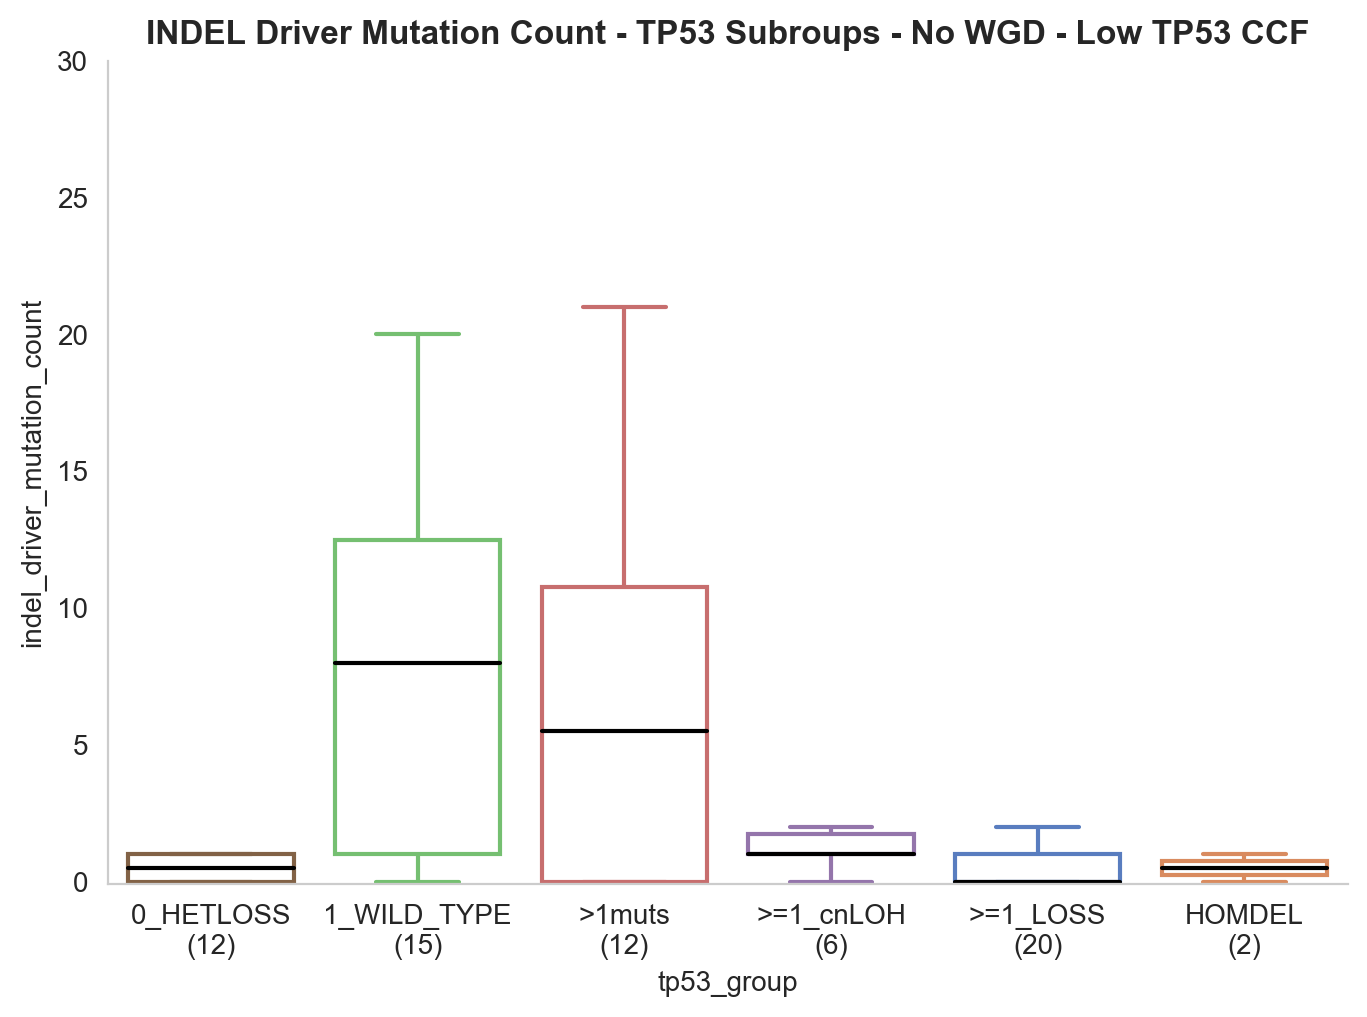

,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,15,8
2,0_HETLOSS,12,0.5
3,,Statistics,p-value
4,,2.46415,0.013734
,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,15,8
2,>=1_LOSS,20,0
3,,Statistics,p-value


In [31]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_low,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='indel_driver_mutation_count',
                  figsize=(8,12),
                  title='INDEL Driver Mutation Count - TP53 Subroups - No WGD - Low TP53 CCF',
                  xlim=[-0.1,30])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer_low,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer_low,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer_low,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

#### GI in 1_WILD_TYPE

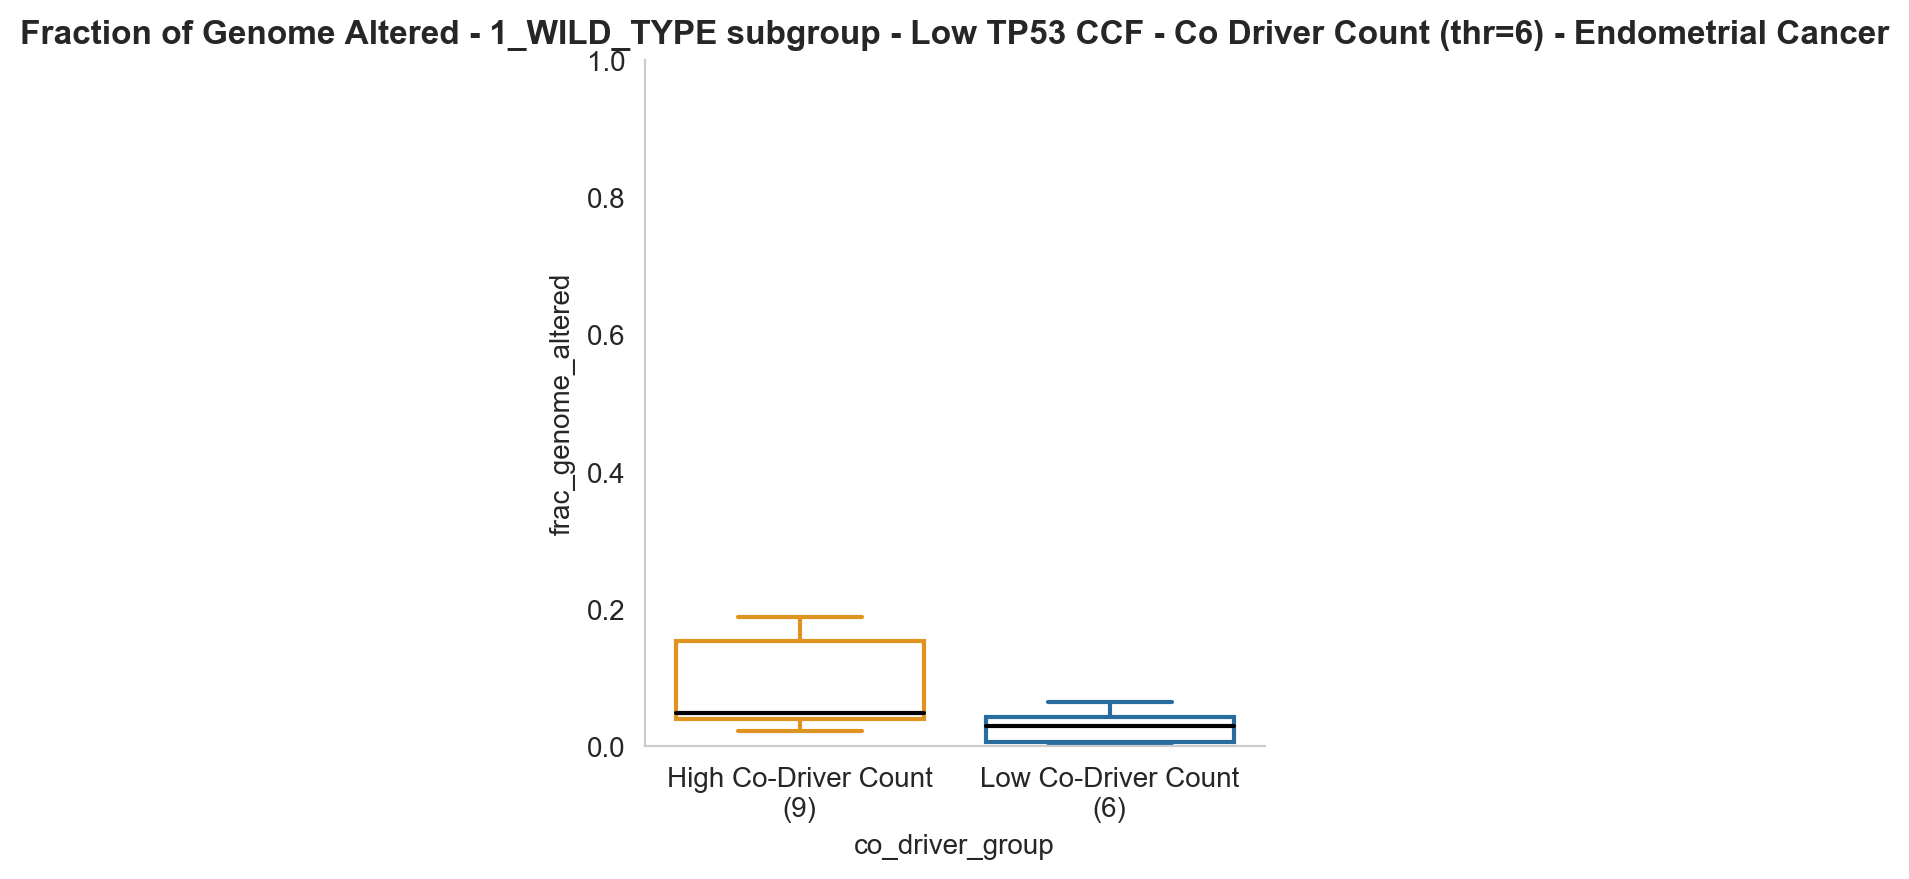

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,9,0.048
2,Low Co-Driver Count,6,0.029
3,,Statistics,p-value
4,,1.94454,0.0518299


In [32]:
master_no_wgd_cancer_low_wt = master_no_wgd_cancer_low[master_no_wgd_cancer_low['tp53_group'] == '1_WILD_TYPE']

thr=6

def get_driver_groups(x):
    if x.driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_low_wt['co_driver_group'] = master_no_wgd_cancer_low_wt.apply(get_driver_groups, axis=1)

fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_low_wt,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 1_WILD_TYPE subgroup - Low TP53 CCF - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_low_wt,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

### High CCF Analysis

In [33]:
master_no_wgd_cancer_high = master_no_wgd_cancer[(master_no_wgd_cancer['ccf_group'] == 'high') | (master_no_wgd_cancer['tp53_count'] == 0)]
get_groupby(master_no_wgd_cancer_high, 'tp53_group', 'count')

,count
tp53_group,
0_HETLOSS,12
1_WILD_TYPE,19
>1muts,9
>=1_LOSS,105
>=1_cnLOH,16
HOMDEL,1


#### # of Drivers  

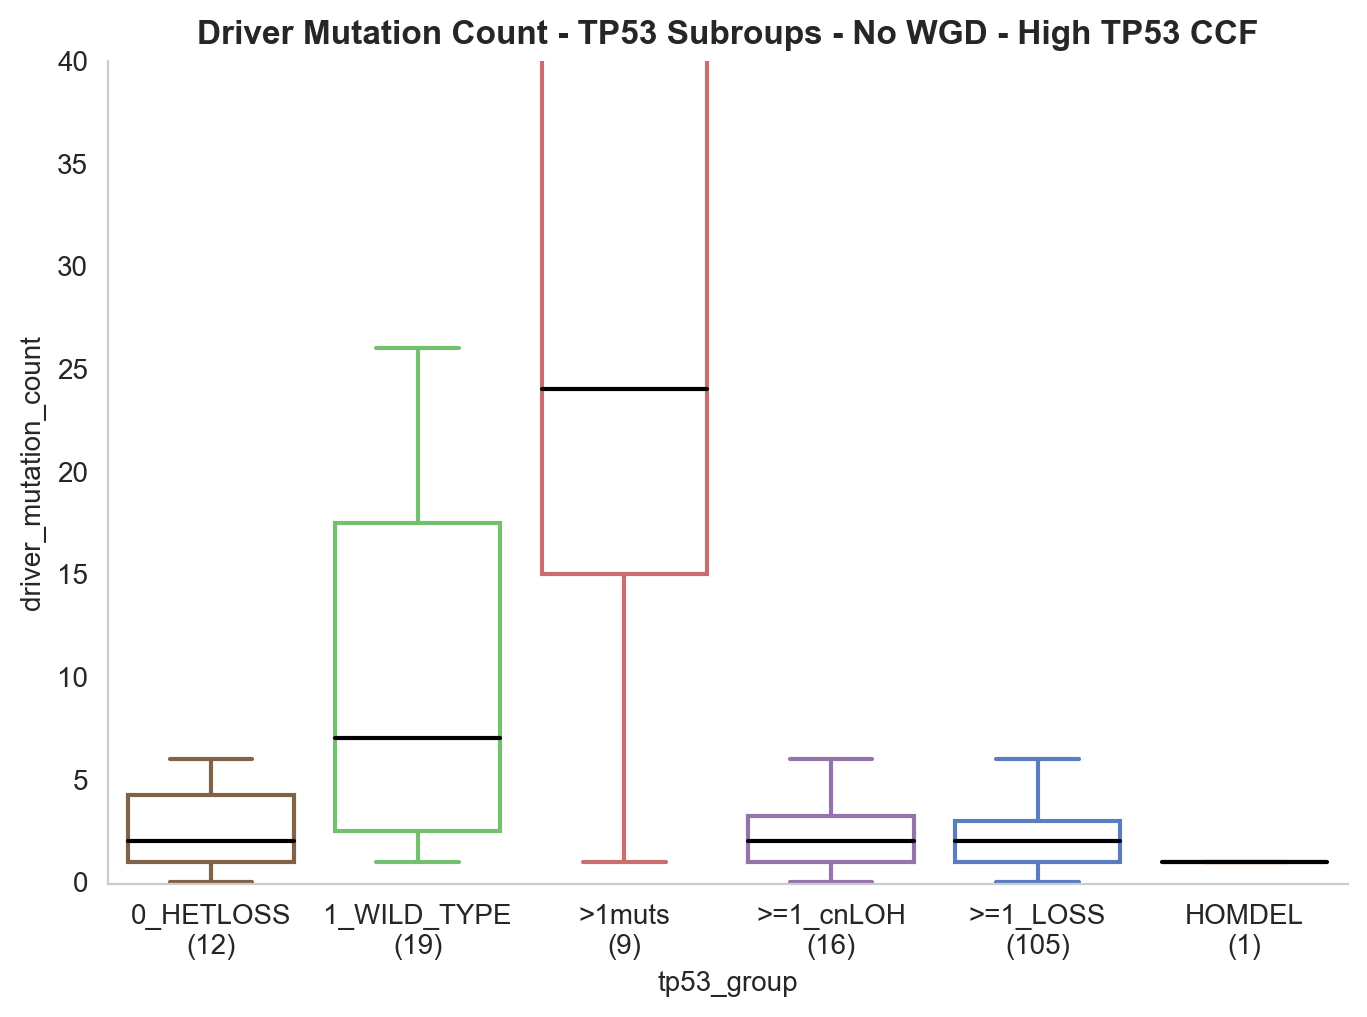

,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,19,2
2,0_HETLOSS,12,0.5
3,,Statistics,p-value
4,,2.21027,0.0270866
,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,19,2
2,>=1_LOSS,105,0
3,,Statistics,p-value


In [34]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_high,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='driver_mutation_count',
                  figsize=(8,12),
                  title='Driver Mutation Count - TP53 Subroups - No WGD - High TP53 CCF',
                  xlim=[-0.1,40])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer_high,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer_high,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer_high,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

#### GI in 1_WILD_TYPE

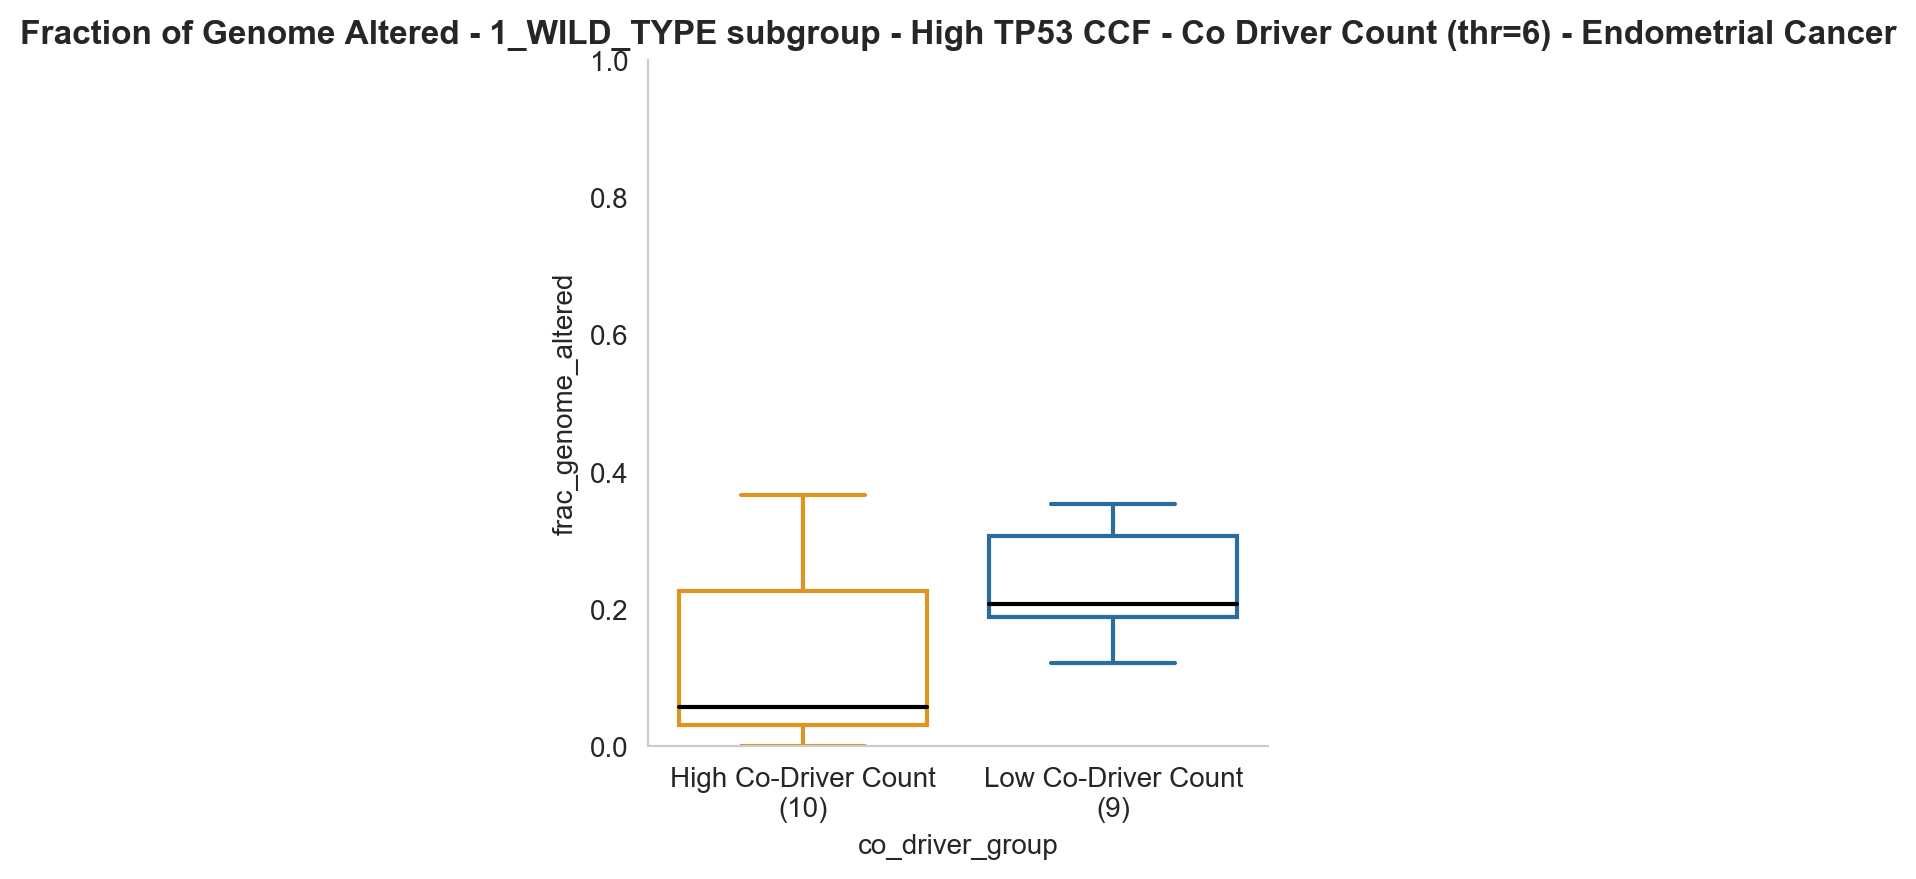

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,10,0.0575
2,Low Co-Driver Count,9,0.207
3,,Statistics,p-value
4,,-1.87794,0.0603891


In [35]:
master_no_wgd_cancer_high_wt = master_no_wgd_cancer_high[master_no_wgd_cancer_high['tp53_group'] == '1_WILD_TYPE']

thr=6

def get_driver_groups(x):
    if x.driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_high_wt['co_driver_group'] = master_no_wgd_cancer_high_wt.apply(get_driver_groups, axis=1)

fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_high_wt,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 1_WILD_TYPE subgroup - High TP53 CCF - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_high_wt,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

In [36]:
get_hotspot_frac(df=master_no_wgd_cancer_high_wt[master_no_wgd_cancer_high_wt['co_driver_group'] == 'High Co-Driver Count'],
                group_type=None,
                group=None)

,0,1,2
0,spot,#,frac
1,11,1,0.35
2,110,1,0.366
3,137,1,0
4,139,1,0.046
5,152,1,0.253
6,196,1,0.054
7,213,1,0.026
8,220,1,0
9,283,1,0.145


In [37]:
get_hotspot_frac(df=master_no_wgd_cancer_high_wt[master_no_wgd_cancer_high_wt['co_driver_group'] == 'Low Co-Driver Count'],
                group_type=None,
                group=None)

,0,1,2
0,spot,#,frac
1,245,2,0.3485
2,248,2,0.248
3,196,1,0.213
4,249,1,0.122
5,266,1,0.353
6,270,1,0.195
7,47,1,0.149


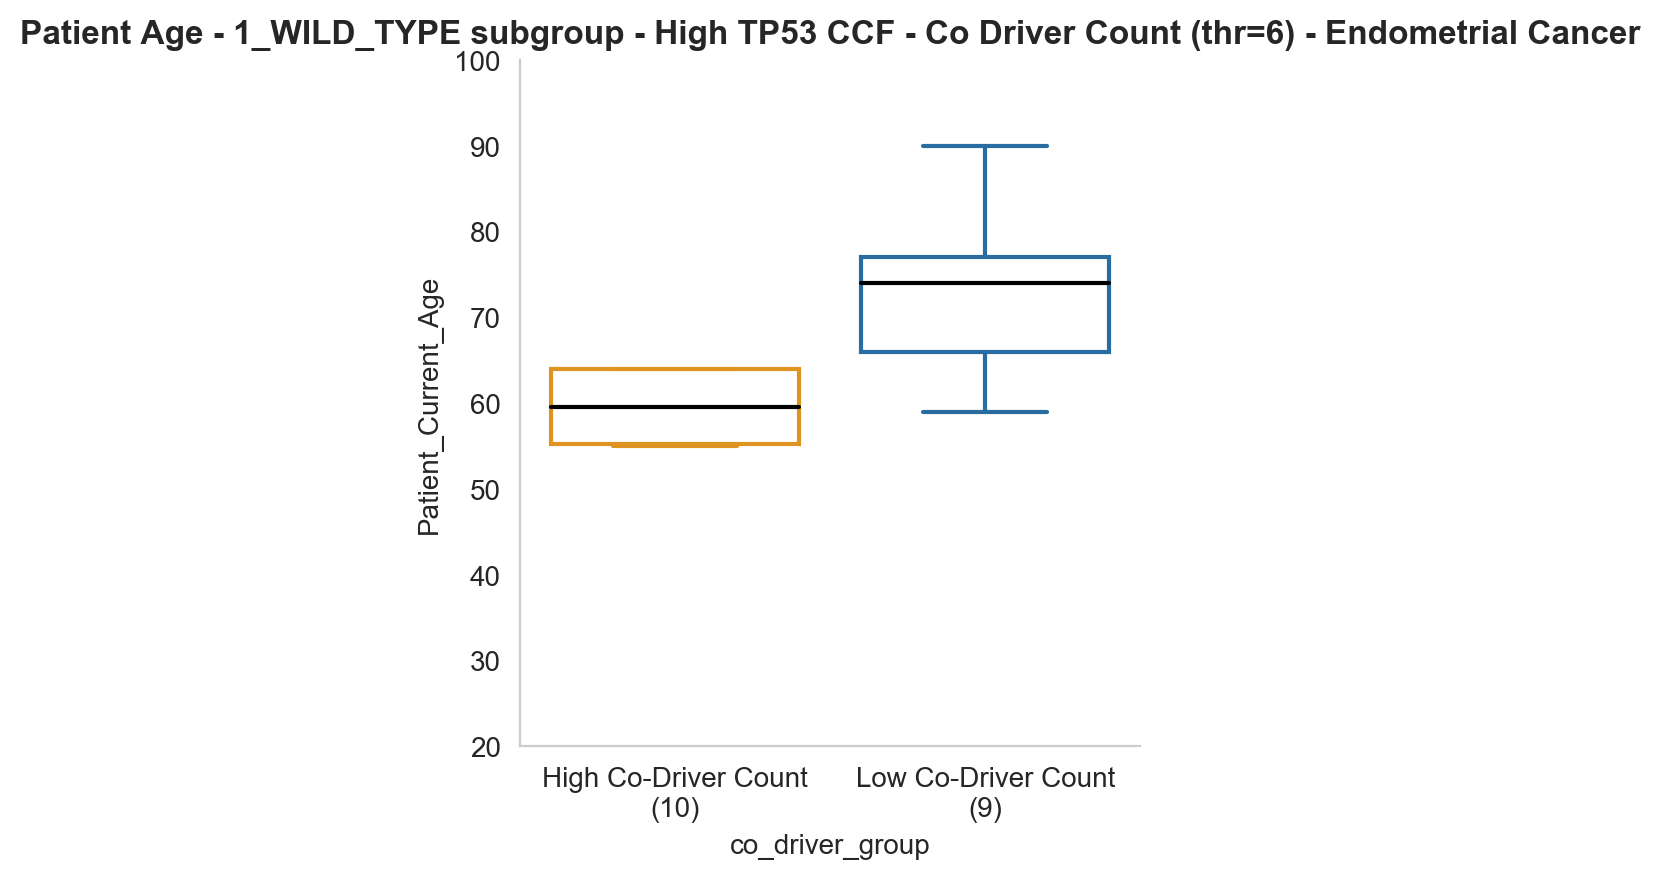

In [38]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_high_wt,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='Patient_Current_Age',
                  figsize=(4,10),
                  title='Patient Age - 1_WILD_TYPE subgroup - High TP53 CCF - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[20,100])
plt.show()



NameError: name 'KaplanMeierFitter' is not defined

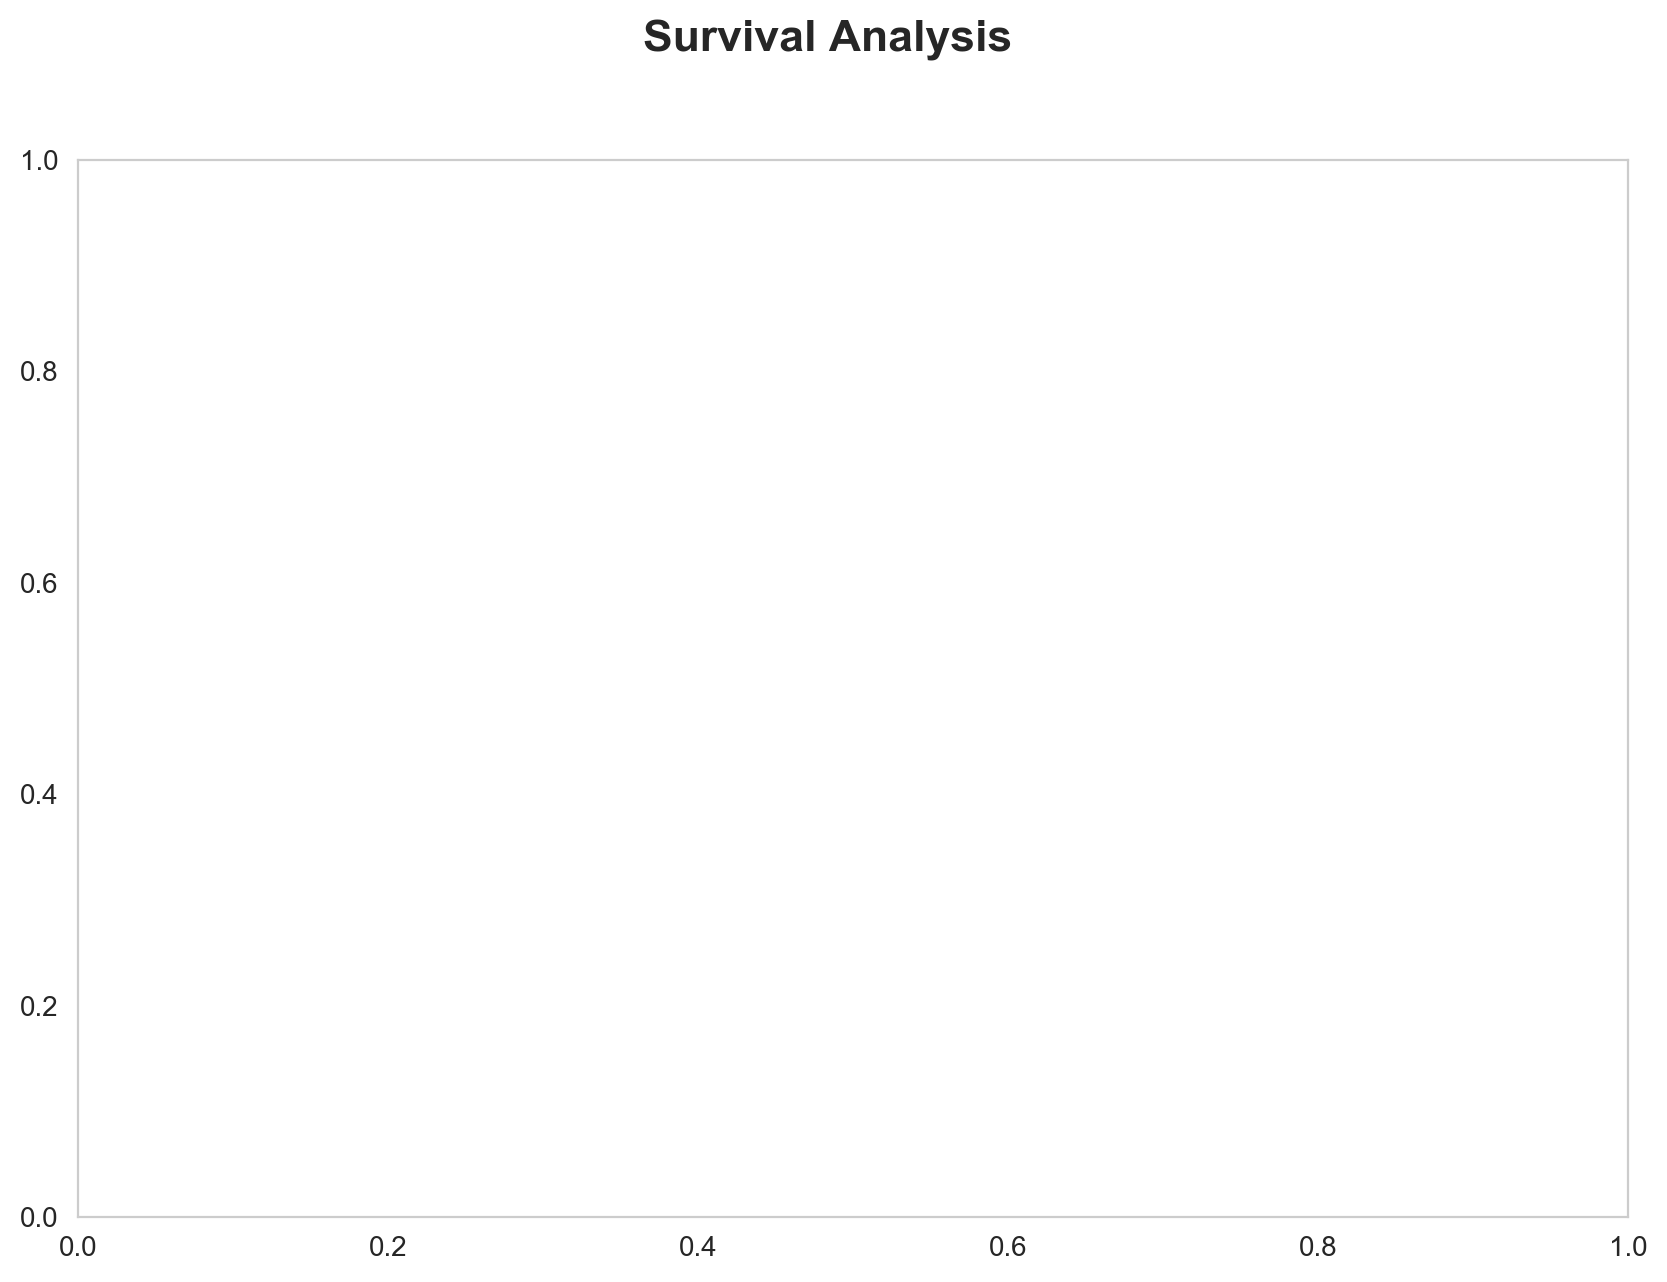

In [39]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
fig.suptitle('Survival Analysis', fontsize=16, weight='bold')
kmf = KaplanMeierFitter()

for group,i in zip(['High Co-Driver Count', 'Low Co-Driver Count'], range(len(['High Co-Driver Count', 'Low Co-Driver Count']))):
    data = master_no_wgd_cancer_high_wt[master_no_wgd_cancer_high_wt['co_driver_group'] == group].dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
    data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)
    kmf.fit(np.array(data['Overall_Survival_Months']), event_observed=np.array(data['Overall Survival Status 0/1']),  label= group)
    kmf.plot_survival_function(color = ['#FF9900' ,'#146EB4'][i], ax=ax)
plt.show()

## Co Driver Analysis

In [40]:
codrivers_cancer = get_major_codrivers(master=master_no_wgd_cancer,
                    maf=maf_cohort_nowgd,
                    head=15)

codrivers_cancer_tp53 = get_major_codrivers(master=master_no_wgd_cancer[master_no_wgd_cancer['tp53_count'] >= 1],
                    maf=maf_cohort_nowgd,
                    head=15)

In [41]:
co_drivers = pd.merge(codrivers_cancer, codrivers_cancer_tp53, on='Hugo_Symbol')
co_drivers.columns = ['cancer', 'cancer_tp53']

In [42]:
co_drivers['ratio'] = co_drivers.apply(lambda x: 100*round(x.cancer_tp53/x.cancer, 4) , axis=1)
co_drivers = co_drivers.sort_values(by='ratio', ascending=False)

In [43]:
co_drivers

,cancer,cancer_tp53,ratio
Hugo_Symbol,,,
FBXW7,81,45,55.56
PIK3CA,347,99,28.53
PIK3R1,238,49,20.59
KMT2B,99,20,20.20
INPPL1,118,23,19.49
JAK1,115,22,19.13
ZFHX3,121,23,19.01
KMT2D,136,25,18.38
CTCF,142,25,17.61


Text(0.5, 1.0, 'Co-Drivers Enrichment in TP53 State')

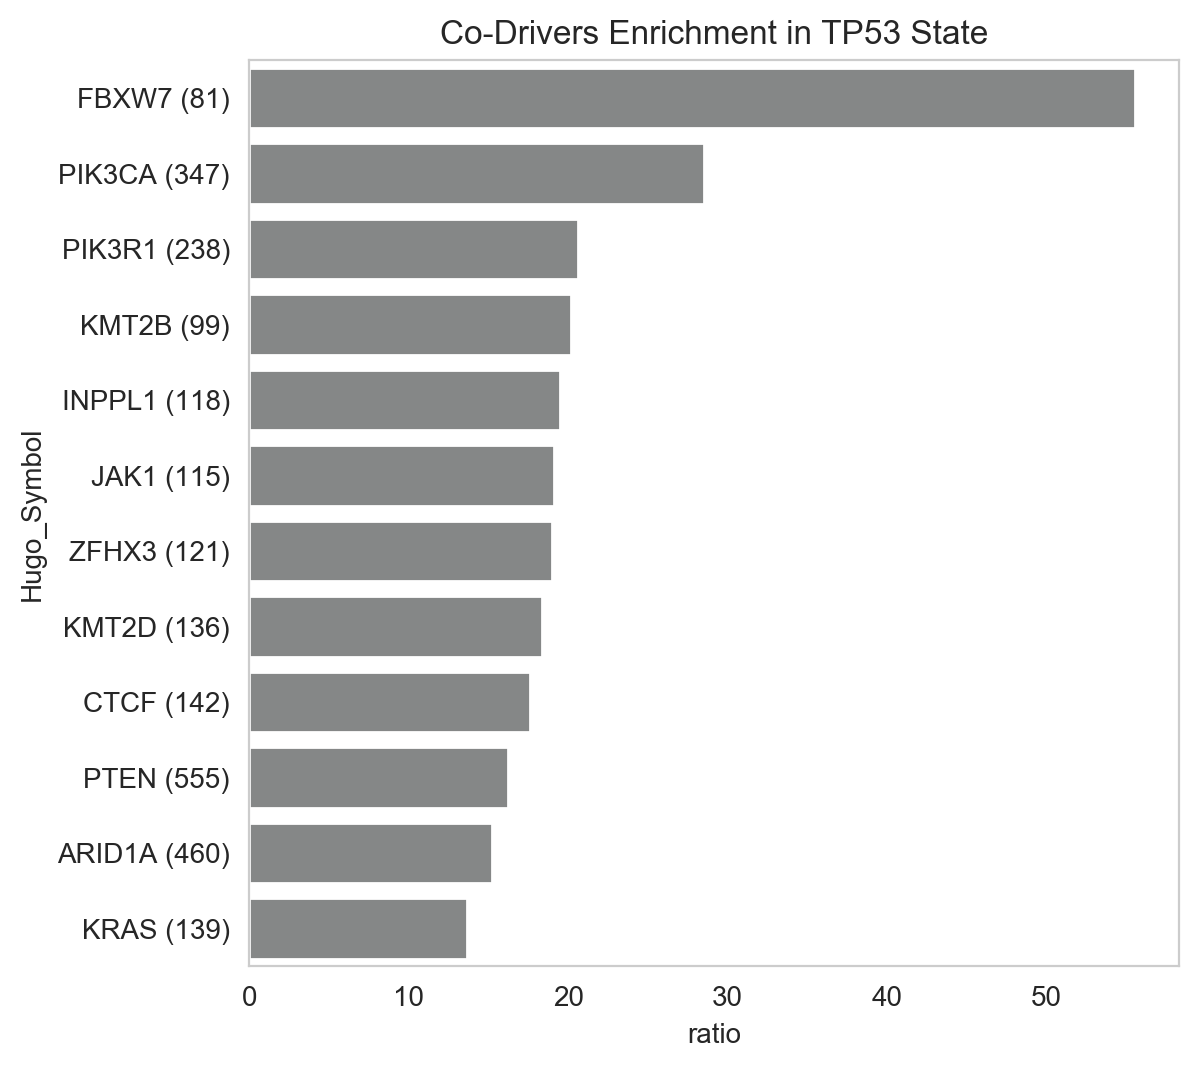

In [44]:
labels = []
for element in co_drivers.index.tolist():
    labels.append(element + ' ('+ str(int(co_drivers.loc[element]['cancer']))+')')

ax = sns.barplot(y=co_drivers.index, x='ratio',data=co_drivers[['ratio']], color='#7F8C8D', saturation=.2)
ax.set_yticklabels(labels)
ax.set_title('Co-Drivers Enrichment in TP53 State')

In [45]:
codrivers_cancer

,count
Hugo_Symbol,
PTEN,555
ARID1A,460
PIK3CA,347
PIK3R1,238
CTNNB1,166
CTCF,142
KRAS,139
KMT2D,136
ZFHX3,121


Text(0.5, 1.0, 'Drivers Frequency in Endometrial Cancer')

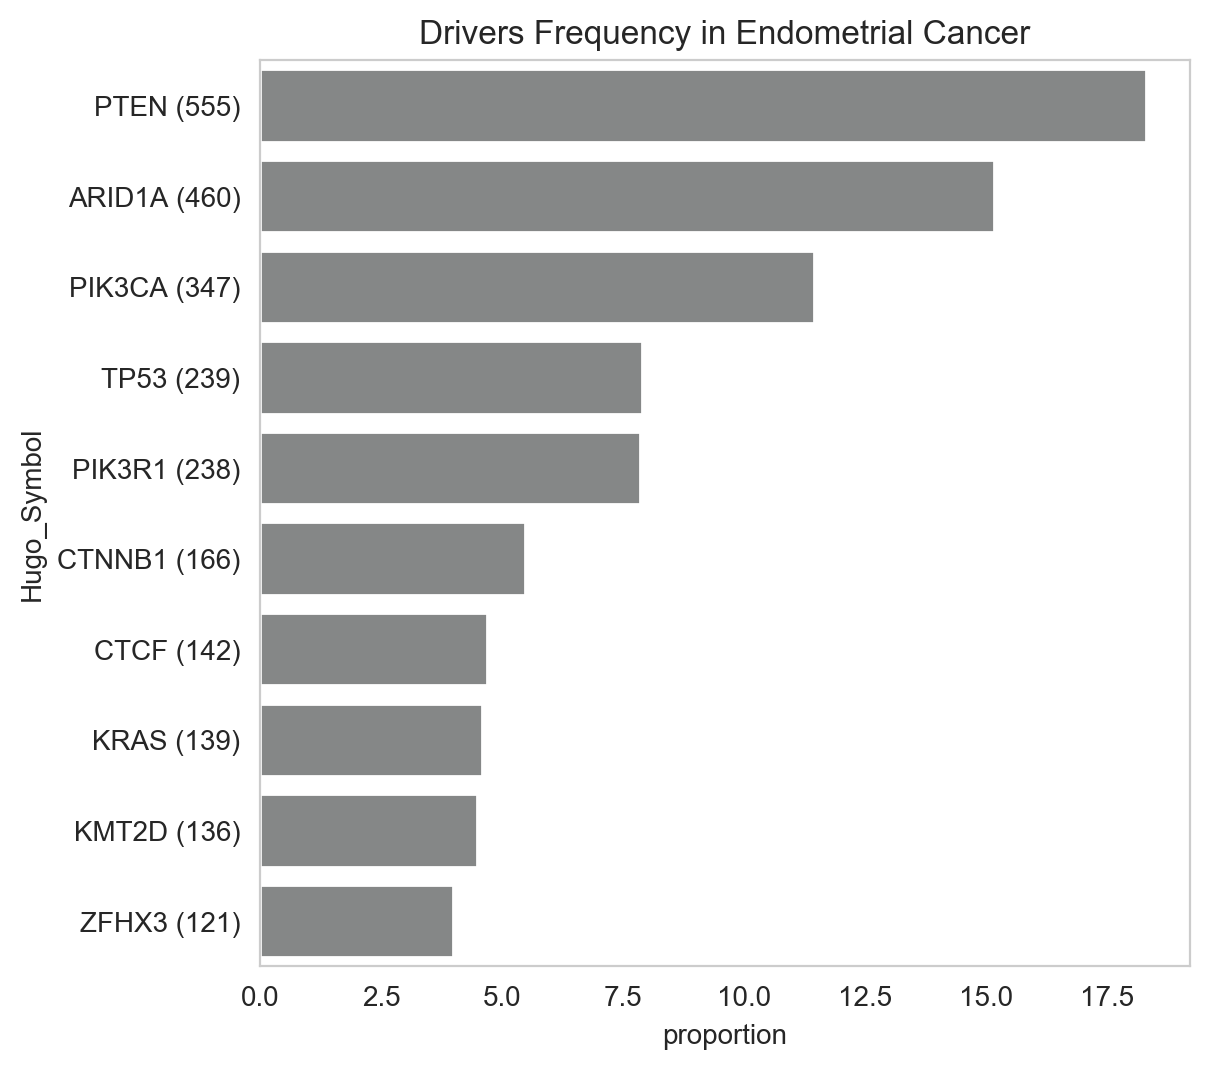

In [46]:
labels = []
codrivers_cancer = get_major_codrivers(master=master_no_wgd_cancer,
                                       maf=maf_cohort_nowgd,
                                       head=15,
                                      tp53=True)

codrivers_cancer['proportion'] = codrivers_cancer.apply(lambda x: 100* round(x['count'] / codrivers_cancer.sum().values[0], 4), axis=1)

for element in codrivers_cancer.head(10).index.tolist():
    labels.append(element + ' ('+ str(int(codrivers_cancer.loc[element]['count']))+')')

ax = sns.barplot(y=codrivers_cancer.head(10).index, x='proportion',data=codrivers_cancer.head(10)[['proportion']], color='#7F8C8D', saturation=.2)
ax.set_yticklabels(labels)
ax.set_title('Drivers Frequency in {}'.format(cancer))

### Co-Drivers per subgroup

In [47]:
co_drivers_res = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_res_group',
                                                group_1='tp53_res',
                                                group_2='no_tp53_res')
co_drivers_res

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
PTEN,46,-8.57,44,7.48
ARID1A,42,-7.82,25,4.25
PIK3CA,28,-5.21,69,11.73
PIK3R1,20,-3.72,31,5.27
ZFHX3,18,-3.35,4,0.68
INPPL1,16,-2.98,6,1.02
CTCF,15,-2.79,8,1.36
KMT2B,15,-2.79,5,0.85
JAK1,15,-2.79,4,0.68


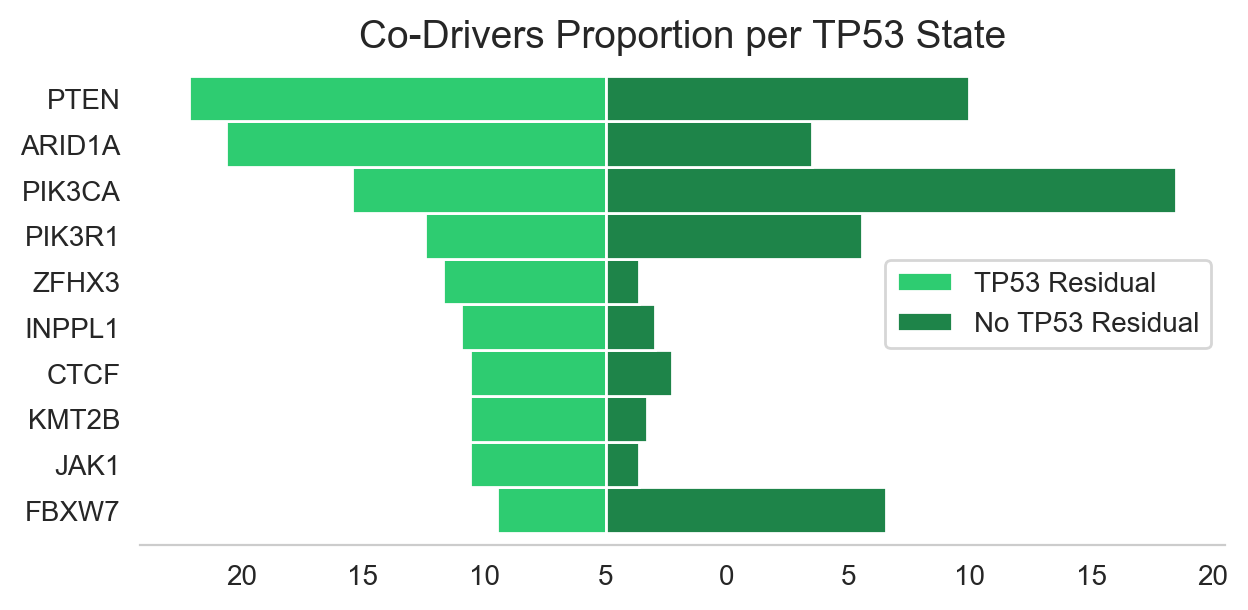

In [48]:
fig=plt.figure(figsize=(7,7))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_res[['proportion_1', 'proportion_2']].head(10)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = ['#2ECC71','#1E8449'])
ax.legend(['TP53 Residual', 'No TP53 Residual'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=14)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [25, 20, 15, 10, 5, 0, 5, 10, 15, 20, 25]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

In [49]:
co_drivers_cnloh_loss = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='>=1_cnLOH',
                                                group_2='>=1_LOSS')
co_drivers_cnloh_loss

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
PIK3CA,11,-17.74,50,17.36
PTEN,8,-12.90,21,7.29
PPP2R1A,5,-8.06,22,7.64
PIK3R1,5,-8.06,21,7.29
ARID1A,4,-6.45,10,3.47
CDKN2A,4,-6.45,1,0.35
FBXW7,2,-3.23,28,9.72
NFE2L2,1,-1.61,2,0.69
U2AF1,1,-1.61,1,0.35


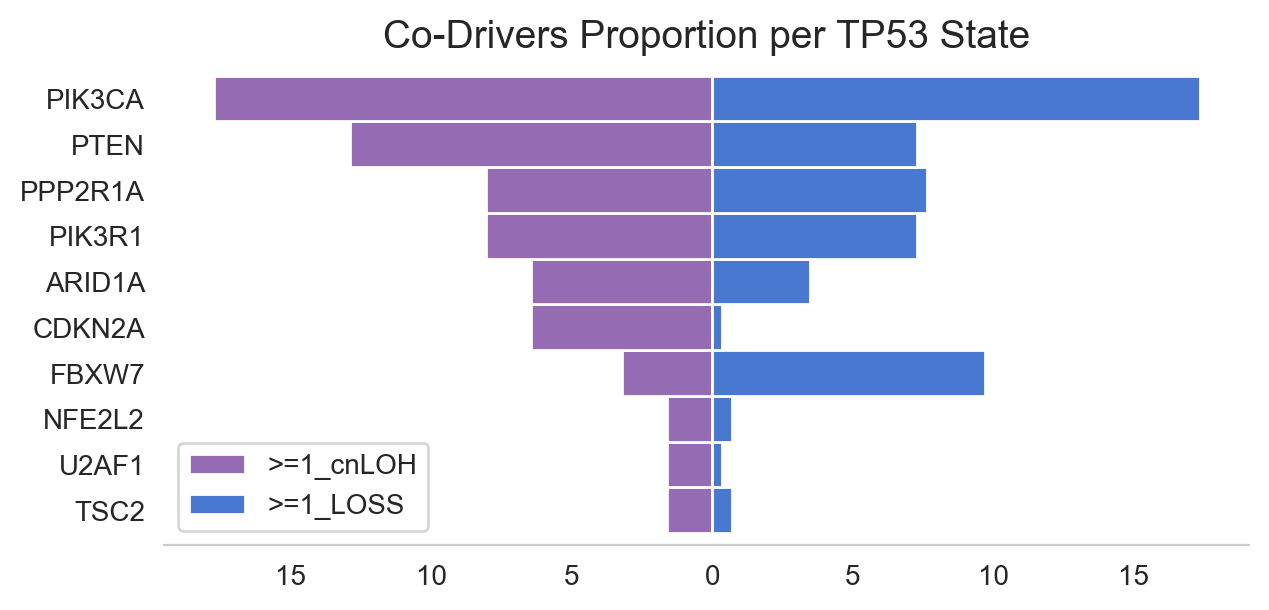

In [50]:
fig=plt.figure(figsize=(7,7))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_cnloh_loss[['proportion_1', 'proportion_2']].head(10)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[4],mc[0]])
ax.legend(['>=1_cnLOH', '>=1_LOSS'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=14)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [20, 15, 10, 5, 0, 5, 10, 15, 20, 25]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

Proportion are the same in both groups

In [51]:
co_drivers_losses = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='0_HETLOSS',
                                                group_2='>=1_LOSS')
co_drivers_losses

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
PIK3R1,4,-11.76,21,7.29
FBXW7,3,-8.82,28,9.72
TERT,2,-5.88,3,1.04
PTEN,2,-5.88,21,7.29
PIK3CA,2,-5.88,50,17.36
KRAS,2,-5.88,9,3.12
ARID1A,2,-5.88,10,3.47
NF1,1,-2.94,4,1.39
SOS1,1,-2.94,1,0.35


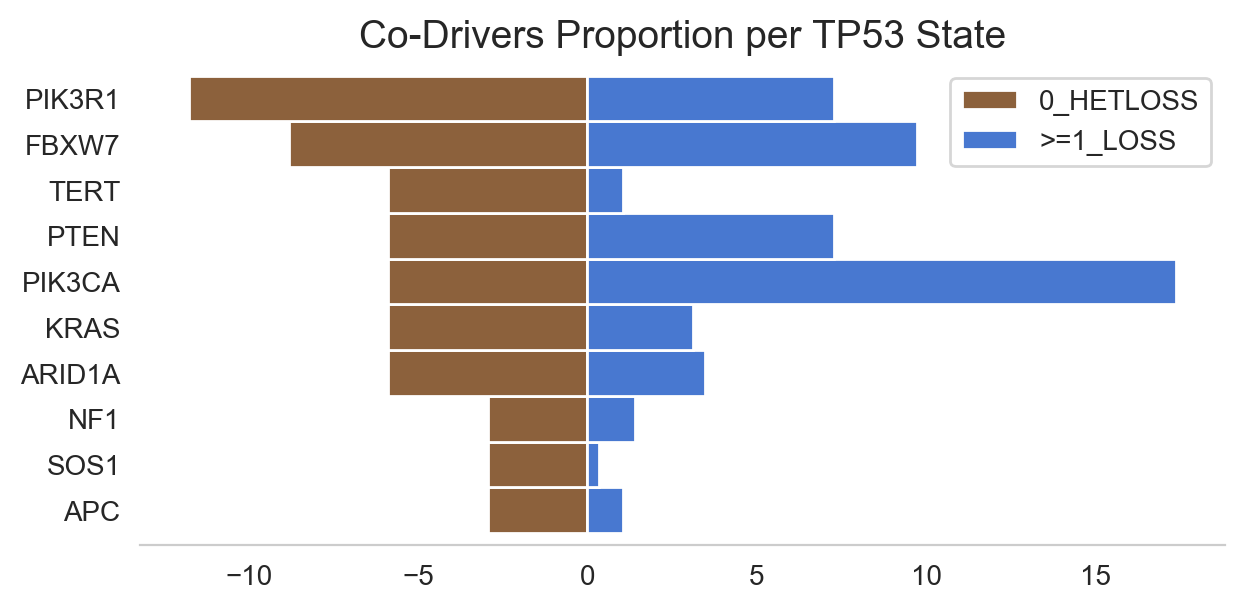

In [52]:
fig=plt.figure(figsize=(7,7))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_losses[['proportion_1', 'proportion_2']].head(10)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[5],mc[0]])
ax.legend(['0_HETLOSS', '>=1_LOSS'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=14)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
#a = [-40, -30, -20, -10, 0, 10, 20, 30, 40]
#ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

Same proportions, enrichment in **APC** and **KRAS**

---

In [53]:
co_drivers_mult_cnloh = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='>1muts',
                                                group_2='>=1_cnLOH')
co_drivers_mult_cnloh

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
PTEN,27,-6.37,8,12.90
ARID1A,23,-5.42,4,6.45
PIK3CA,11,-2.59,11,17.74
PIK3R1,9,-2.12,5,8.06
KMT2D,9,-2.12,1,1.61
RB1,9,-2.12,1,1.61
FBXW7,7,-1.65,2,3.23
ZFHX3,7,-1.65,1,1.61
PPP2R1A,6,-1.42,5,8.06


In [54]:
get_major_codrivers(master=master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>1muts'],
                    maf=maf_cohort_nowgd,
                    head=100)

,count
Hugo_Symbol,
PTEN,27
ARID1A,23
CTCF,12
JAK1,11
PIK3CA,11
KMT2B,11
ATM,11
INPPL1,10
PIK3R1,9


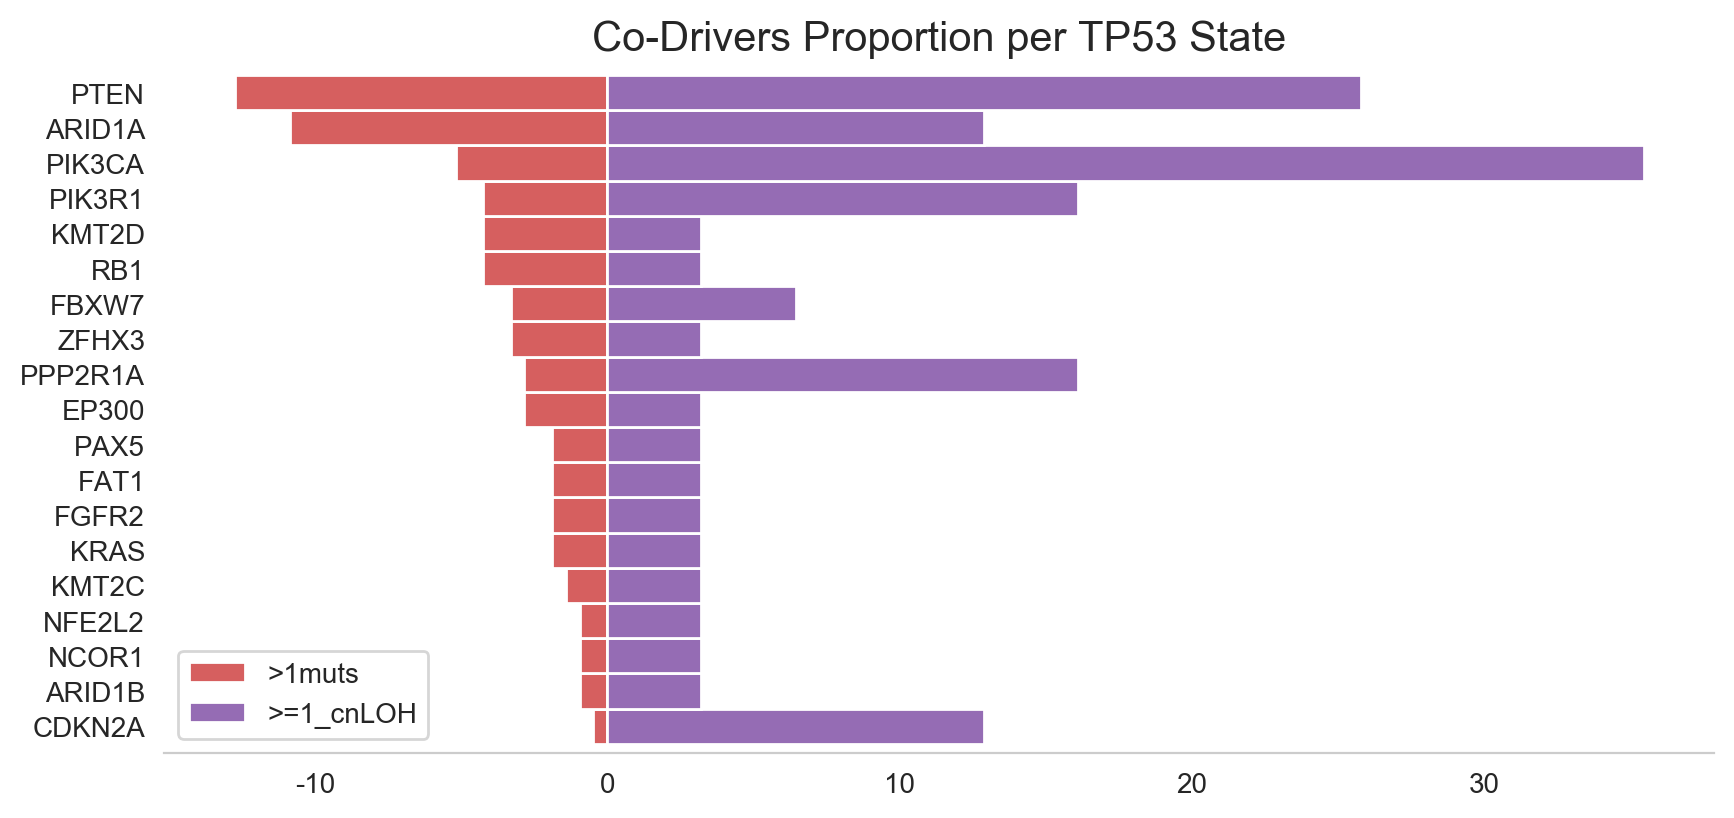

In [55]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_mult_cnloh[['proportion_1', 'proportion_2']].head(20)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[3],mc[4]])
ax.legend(['>1muts', '>=1_cnLOH'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=15)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [-20, -10, 0, 10, 20, 30, 40]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

In [56]:
co_drivers_wt_loss = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='1_WILD_TYPE',
                                                group_2='>=1_LOSS')
co_drivers_wt_loss

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
PTEN,32,-8.65,21,7.29
ARID1A,29,-7.84,10,3.47
PIK3CA,23,-6.22,50,17.36
PIK3R1,12,-3.24,21,7.29
ZFHX3,11,-2.97,3,1.04
INPPL1,11,-2.97,1,0.35
CTCF,9,-2.43,2,0.69
JAK1,8,-2.16,1,0.35
FBXW7,8,-2.16,28,9.72


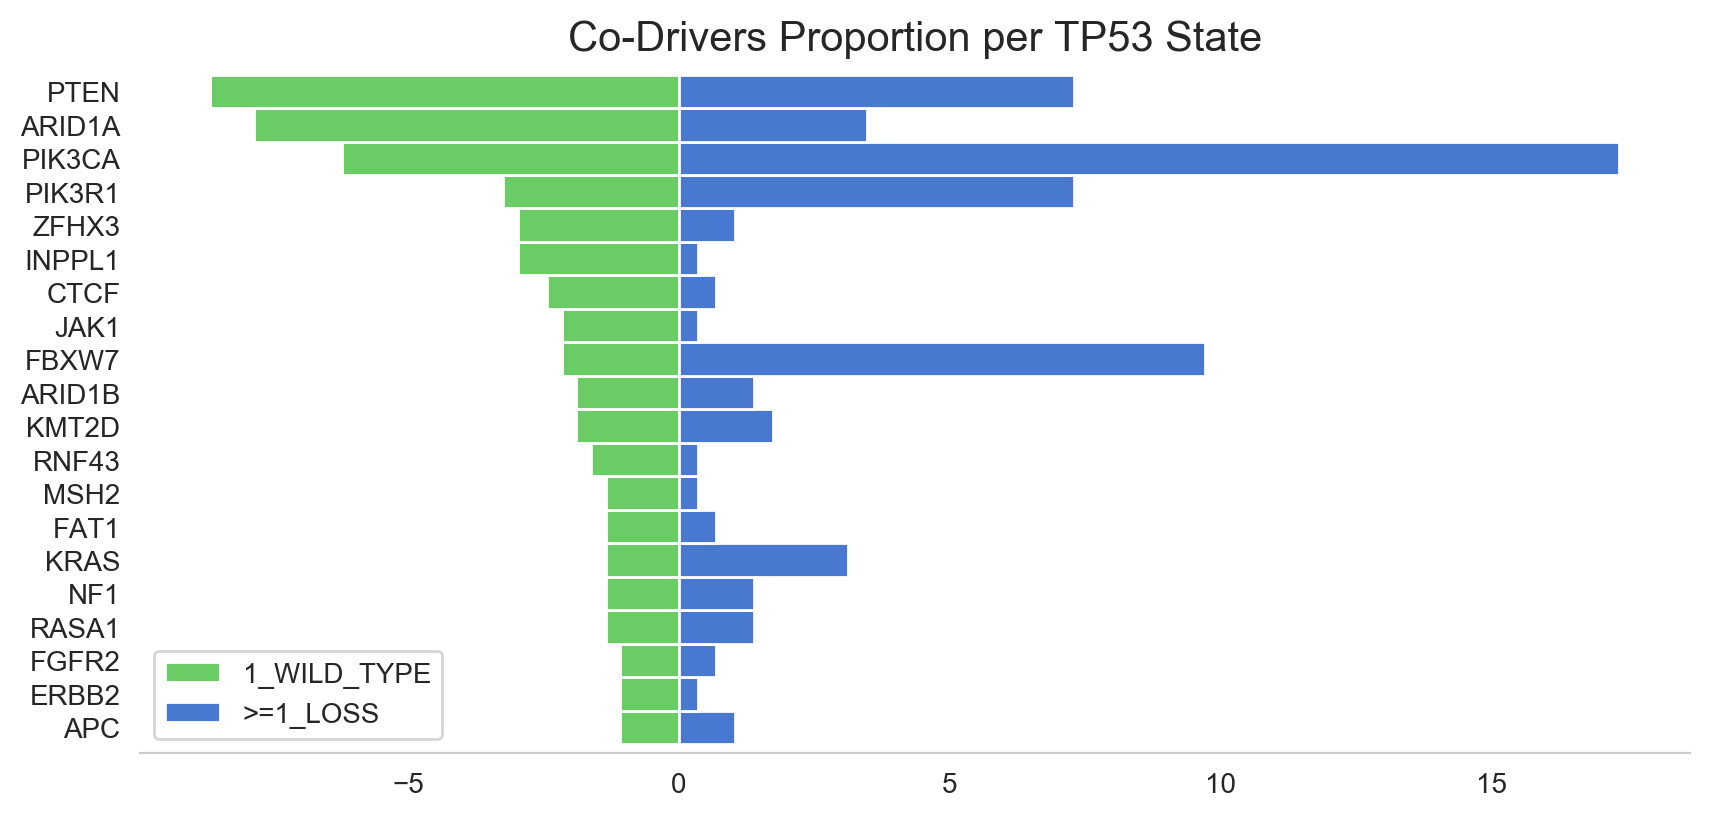

In [57]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_wt_loss[['proportion_1', 'proportion_2']].head(20)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[2],mc[0]])
ax.legend(['1_WILD_TYPE', '>=1_LOSS'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=15)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
#a = [-10, 0, 10, 20, 30, 40]
#ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

#### Comparison with WGD Cohort (WGD - TP53 - LOH)

In [58]:
def get_major_codrivers(master: pd.DataFrame, maf: pd.DataFrame, head:int = 10):
    samples = master.Tumor_Id.tolist()
    maf_filtered = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['driver'] == True][maf['Hugo_Symbol'] != 'TP53']
    h = pd.DataFrame(maf_filtered[['Hugo_Symbol']].groupby(['Hugo_Symbol']).size())
    h.columns = ['count']
    h = h.sort_values(by='count', ascending=False).head(head)
    
    return(h)

def create_co_drivers_table_wgd(master_1: pd.DataFrame, master_2: pd.DataFrame, group_type:str,  group_1: str):
    master_group_1 = master_1[master_1[group_type] == group_1]
    co_drivers_group_1 = get_major_codrivers(master=master_group_1,
                        maf=maf_cohort_nowgd,
                       head=100)
    co_drivers_group_1['proportion_1'] = co_drivers_group_1.apply(lambda x: 100* round(x['count'] / co_drivers_group_1.sum().values[0], 4), axis=1)
    
    master_group_2 = master_2[master_2['tp53_count'] >=1][master_2['tp53_loh_status'] == True]
    co_drivers_group_2 = get_major_codrivers(master=master_group_2,
                        maf=maf_cohort_wgd,
                       head=100)
    co_drivers_group_2['proportion_2'] = co_drivers_group_2.apply(lambda x: 100* round(x['count'] / co_drivers_group_2.sum().values[0], 4), axis=1)
    
    co_drivers_groups = pd.merge(co_drivers_group_2, co_drivers_group_1, on='Hugo_Symbol')
    co_drivers_groups['proportion_2'] = - co_drivers_groups['proportion_2']
    
    return co_drivers_groups

In [59]:
co_drivers_wgd_loss = create_co_drivers_table_wgd(master_1=master_no_wgd_cancer,
                            master_2=master_wgd_cancer,
                            group_type='tp53_group',
                            group_1='>=1_LOSS')
co_drivers_wgd_loss

,count_x,proportion_2,count_y,proportion_1
Hugo_Symbol,,,,
PIK3CA,50,-18.12,50,17.36
PPP2R1A,39,-14.13,22,7.64
PIK3R1,27,-9.78,21,7.29
PTEN,20,-7.25,21,7.29
FBXW7,17,-6.16,28,9.72
KRAS,11,-3.99,9,3.12
ARID1A,7,-2.54,10,3.47
SPOP,6,-2.17,8,2.78
RB1,5,-1.81,4,1.39


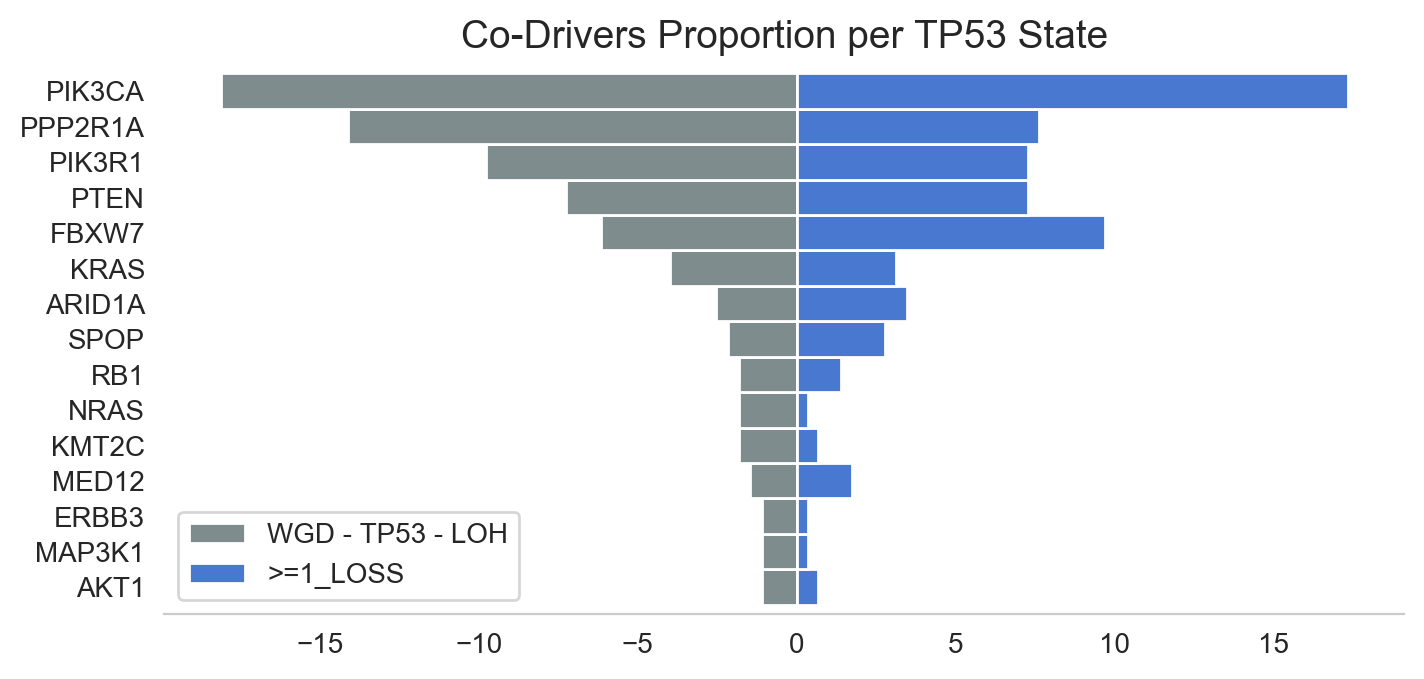

In [60]:
fig=plt.figure(figsize=(8,8))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_wgd_loss[['proportion_2', 'proportion_1']].head(15)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = ['#7F8C8D',mc[0]])
ax.legend(['WGD - TP53 - LOH', '>=1_LOSS'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=14)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
#a = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]
#ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

### Genome Instability Associated

In [61]:
def get_master_codrivers(master: pd.DataFrame, maf: pd.DataFrame, symbol: str):
    samples = master.Tumor_Id.tolist()
    samples_final = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['Hugo_Symbol'] == symbol].Tumor_Sample_Barcode.tolist()

    master_filtered = master[master.Tumor_Id.isin(samples_final)]
    
    return master_filtered

#### >=1_cnLOH

In [62]:
master_no_wgd_cancer_cnloh = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>=1_cnLOH']
master_PIK3CA = get_master_codrivers(master=master_no_wgd_cancer_cnloh,
                                   maf=maf_cohort_nowgd,
                                   symbol='PIK3CA')

master_RB1 = get_master_codrivers(master=master_no_wgd_cancer_cnloh,
                                   maf=maf_cohort_nowgd,
                                   symbol='RB1')

master_no_wgd_cancer_cnloh['data'] = '>=1_cnLOH'
master_RB1['data'] = 'RB1'
master_PIK3CA['data'] = 'PIK3CA'

masters = [master_no_wgd_cancer_cnloh, master_RB1, master_PIK3CA]
allMasters = pd.concat(masters)

Text(0.5, 0, '')

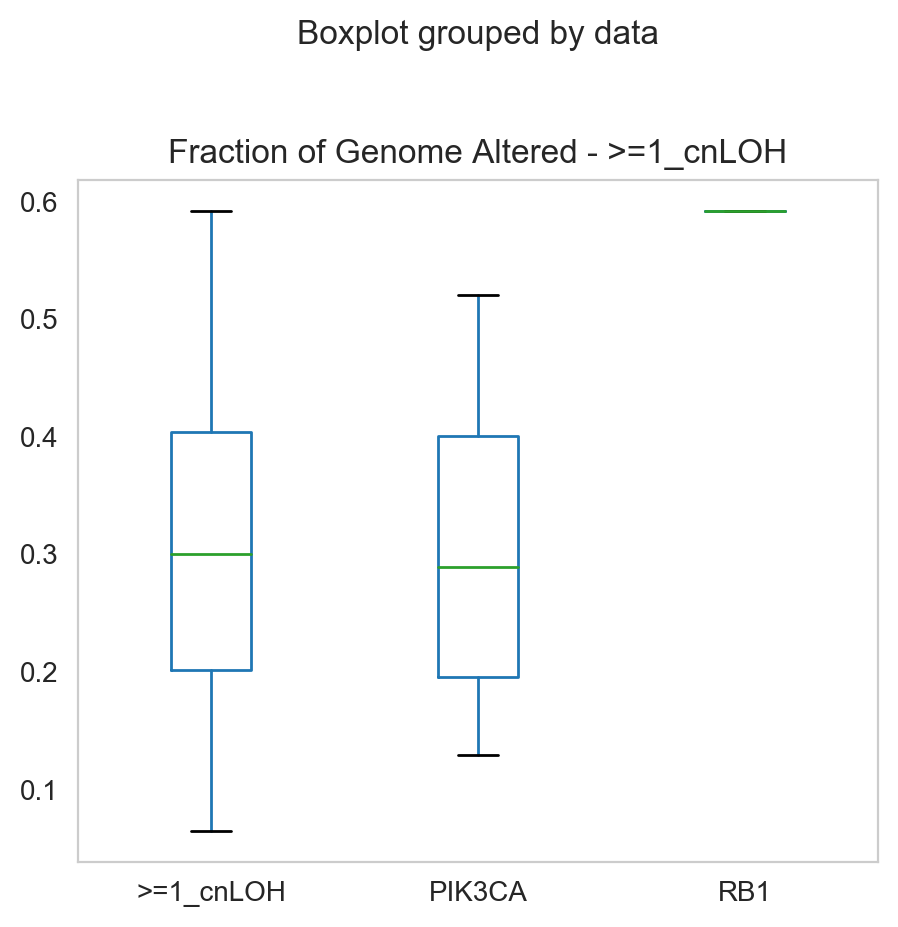

In [63]:
fig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - >=1_cnLOH')
ax.set_xlabel('')

#### >=1_LOSS

In [64]:
master_no_wgd_cancer_loss = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>=1_LOSS']
master_CDH1 = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='CDH1')

master_GATA3 = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='GATA3')

master_PIK3CA = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='PIK3CA')

master_no_wgd_cancer_loss['data'] = '>=1_loss'
master_CDH1['data'] = 'CDH1'
master_GATA3['data'] = 'GATA3'
master_PIK3CA['data'] = 'PIK3CA'

masters = [master_no_wgd_cancer_loss, master_CDH1, master_GATA3, master_PIK3CA]
allMasters = pd.concat(masters)

Text(0.5, 0, '')

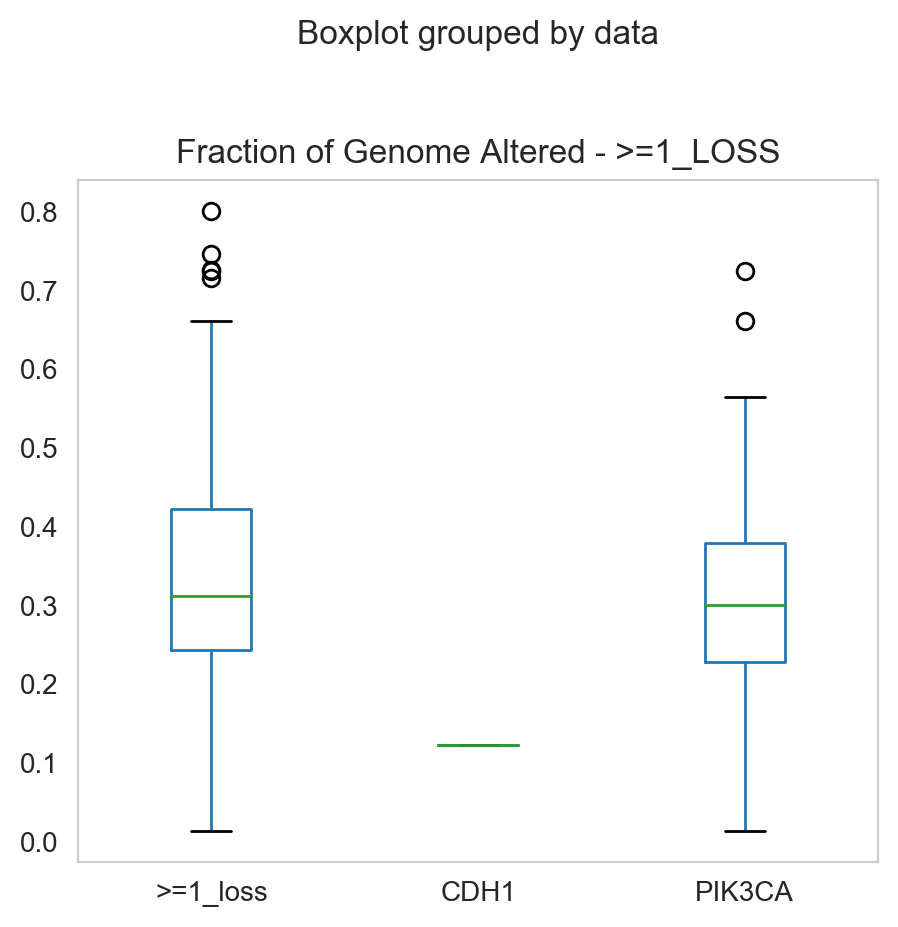

In [65]:
fig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - >=1_LOSS')
ax.set_xlabel('')

#### 0_HETLOSS

In [66]:
master_no_wgd_cancer_loss = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '0_HETLOSS']
master_ = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='APC')

master_CDH1 = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='CDH1')

master_GATA3 = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='GATA3')

master_PIK3CA = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='PIK3CA')

master_no_wgd_cancer_loss['data'] = '>=1_loss'
master_CDH1['data'] = 'CDH1'
master_GATA3['data'] = 'GATA3'
master_PIK3CA['data'] = 'PIK3CA'

masters = [master_no_wgd_cancer_loss, master_CDH1, master_GATA3, master_PIK3CA]
allMasters = pd.concat(masters)

Text(0.5, 0, '')

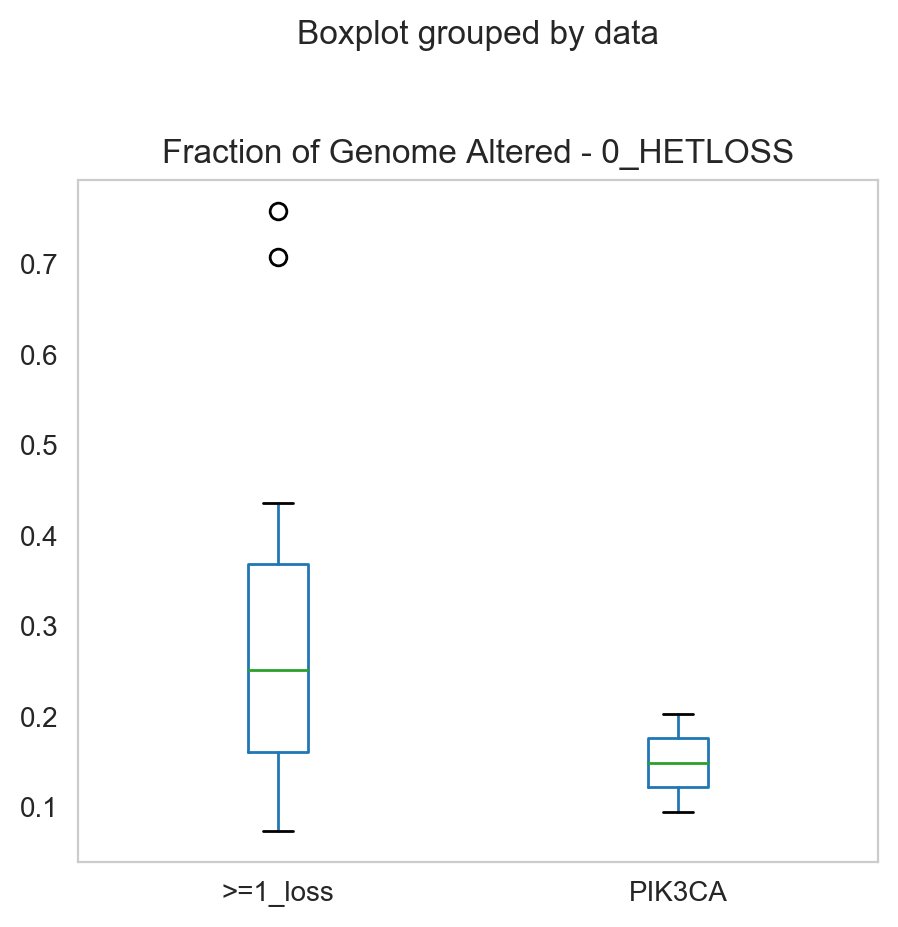

In [67]:
fig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - 0_HETLOSS')
ax.set_xlabel('')

#### 1_WILD_TYPE

In [68]:
master_no_wgd_cancer_wt = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '1_WILD_TYPE']

master_PIK3CA = get_master_codrivers(master=master_no_wgd_cancer_wt,
                                   maf=maf_cohort_nowgd,
                                   symbol='PIK3CA')

master_MAP3K1 = get_master_codrivers(master=master_no_wgd_cancer_wt,
                                   maf=maf_cohort_nowgd,
                                   symbol='MAP3K1')


master_no_wgd_cancer_wt['data'] = '1_WT'
master_PIK3CA['data'] = 'PIK3CA'
master_MAP3K1['data'] = 'MAP3K1'

masters = [master_no_wgd_cancer_wt, master_PIK3CA, master_MAP3K1]
allMasters = pd.concat(masters)

Text(0.5, 0, '')

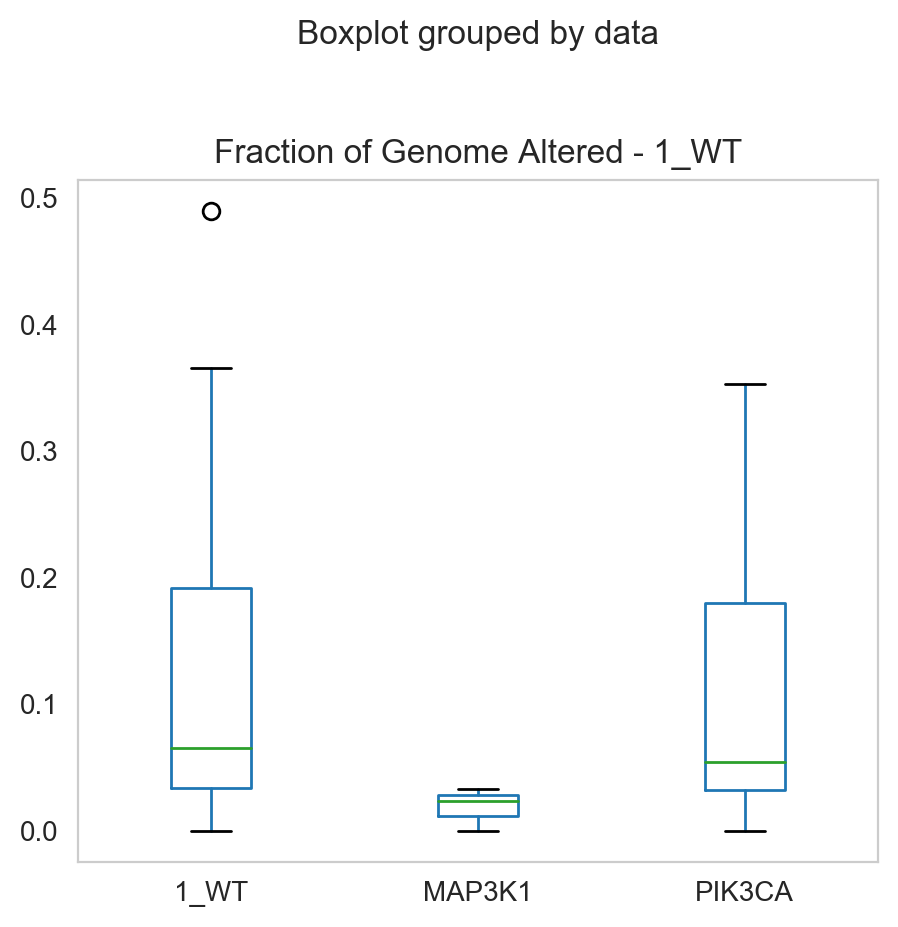

In [69]:
fig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - 1_WT')
ax.set_xlabel('')

## CCF / VAF Analysis
Same here we take only samples with exactly 1 tp53 mutation (*master_hotspot*).

We have to define groups for CCF to see if there are differences between those groups. To have an idea of the CCF distribution we show here the distribution coming from the *cancer_panel*.

<img src="breast_ccf.png" width=1000 length=1000>

We see that our tp53_ccf distribution is very high for all subgroups. *>=1_LOSS* and *0_HETLOSS* are the biggest subgroups - by far - and >=1_LOSS* has a very high CCF median.

It will be hard to cut the cohort based on the CCF. Let's try and see the size of the subcohorts:

In [70]:
master_ccf = master_no_wgd_cancer[(master_no_wgd_cancer['tp53_count'] == 1) | (master_no_wgd_cancer['tp53_group'] == '0_HETLOSS')]

In [71]:
thr_ccf_1 = 0.9 ; thr_ccf_2 = 0.95

def ccf_subgroup(x):
    if x.tp53_ccf_1 <= thr_ccf_1: return 'low'
    elif x.tp53_ccf_1 <= thr_ccf_2: return 'medium'
    elif x.tp53_ccf_1 > thr_ccf_2: return 'high'

master_ccf['ccf_group'] = master_ccf.apply(ccf_subgroup, axis=1)
get_groupby(master_ccf, 'ccf_group', 'count')

,count
ccf_group,
high,118
low,43
medium,26


In [72]:
thr_vaf_1 = 0.3 ; thr_vaf_2 = 0.4

def vaf_subgroup(x):
    if x.tp53_vaf_1 <= thr_vaf_1: return 'low'
    elif x.tp53_vaf_1 <= thr_vaf_2: return 'medium'
    elif x.tp53_vaf_1 > thr_vaf_2: return 'high'

master_ccf['vaf_group'] = master_ccf.apply(vaf_subgroup, axis=1)       
get_groupby(master_ccf, 'vaf_group', 'count')

,count
vaf_group,
high,73
low,85
medium,30


### VAF Analysis

#### No VAF Cut

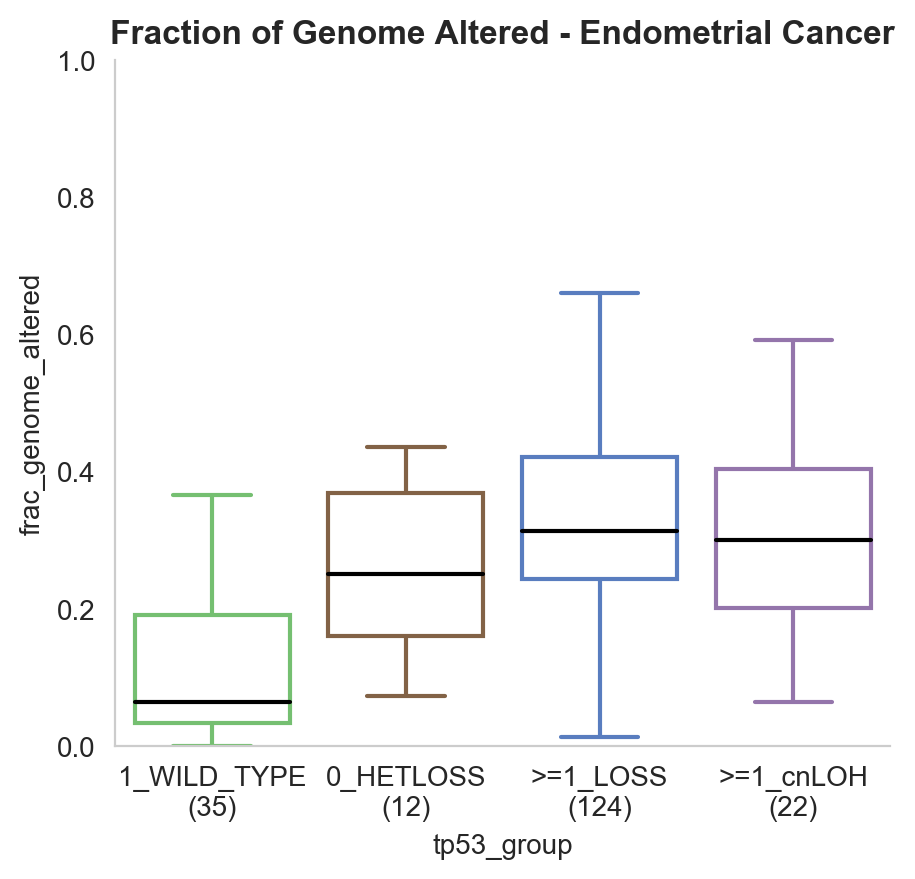

,0,1,2
0,,size,frac_genome_altered
1,0_HETLOSS,12,0.2515
2,1_WILD_TYPE,35,0.065
3,,Statistics,p-value
4,,2.85451,0.00431036


In [73]:
fig, ax = boxplot_sampletype(df=master_ccf,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_ccf,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['0_HETLOSS', '1_WILD_TYPE'])

#### Low VAF

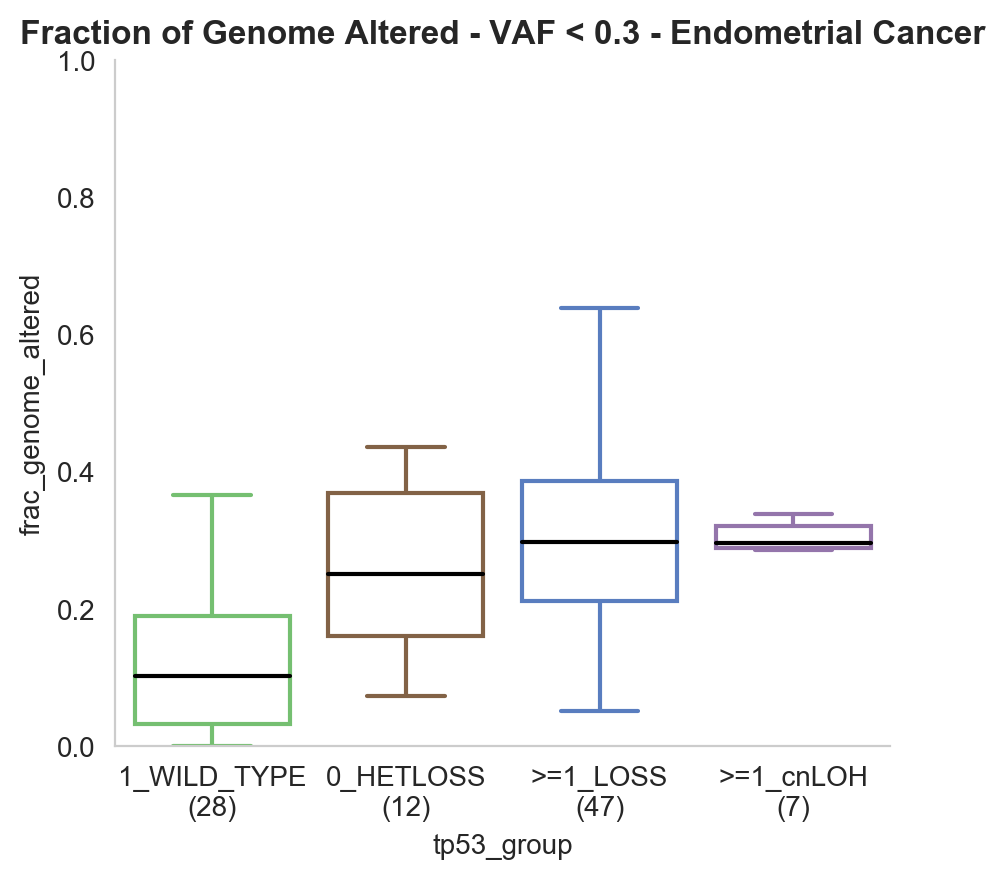

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,28,0.103
2,>=1_LOSS,47,0.298
3,,Statistics,p-value
4,,-4.73194,2.22379e-06


In [74]:
master_low = master_ccf[(master_ccf['vaf_group'] == 'low') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_low,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - VAF < {} - {}'.format(thr_vaf_1,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_low,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '>=1_LOSS'])

#### Medium VAF

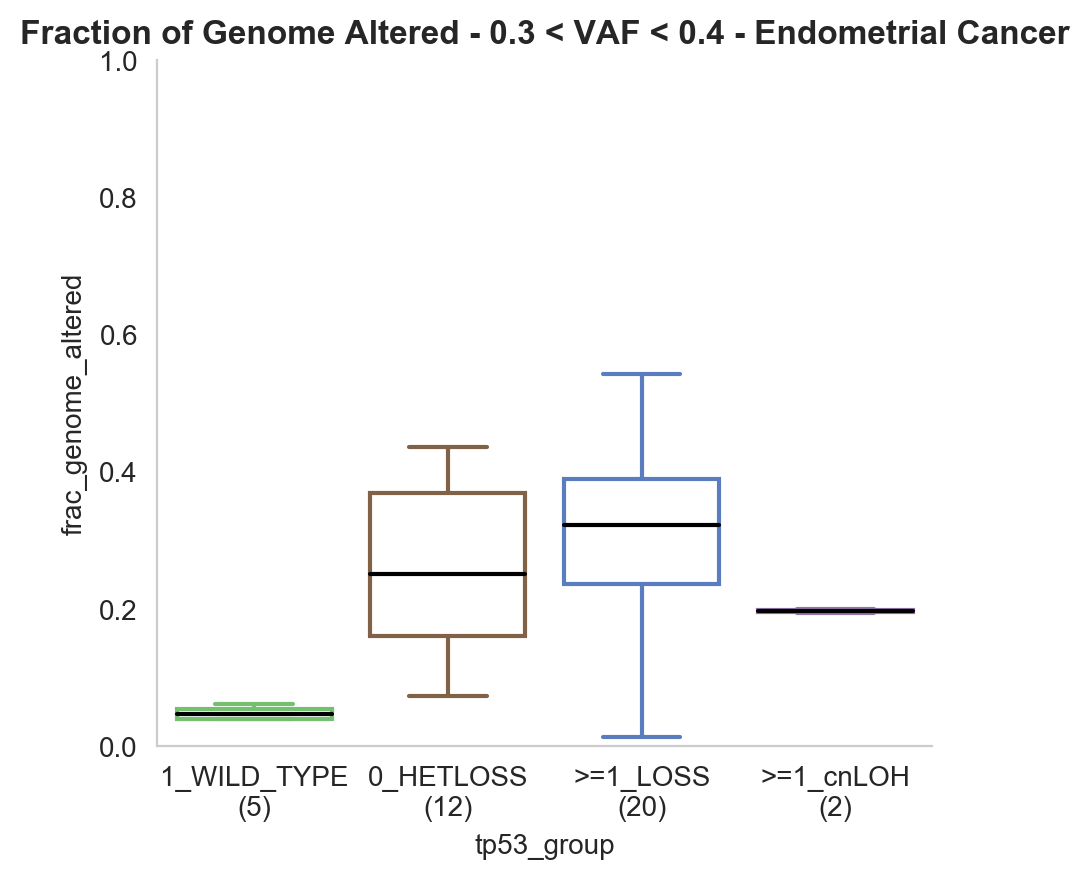

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,5,0.047
2,0_HETLOSS,12,0.2515
3,,Statistics,p-value
4,,-3.16228,0.0015654


In [75]:
master_med = master_ccf[(master_ccf['vaf_group'] == 'medium') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_med,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {} < VAF < {} - {}'.format(thr_vaf_1,thr_vaf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_med,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### High VAF

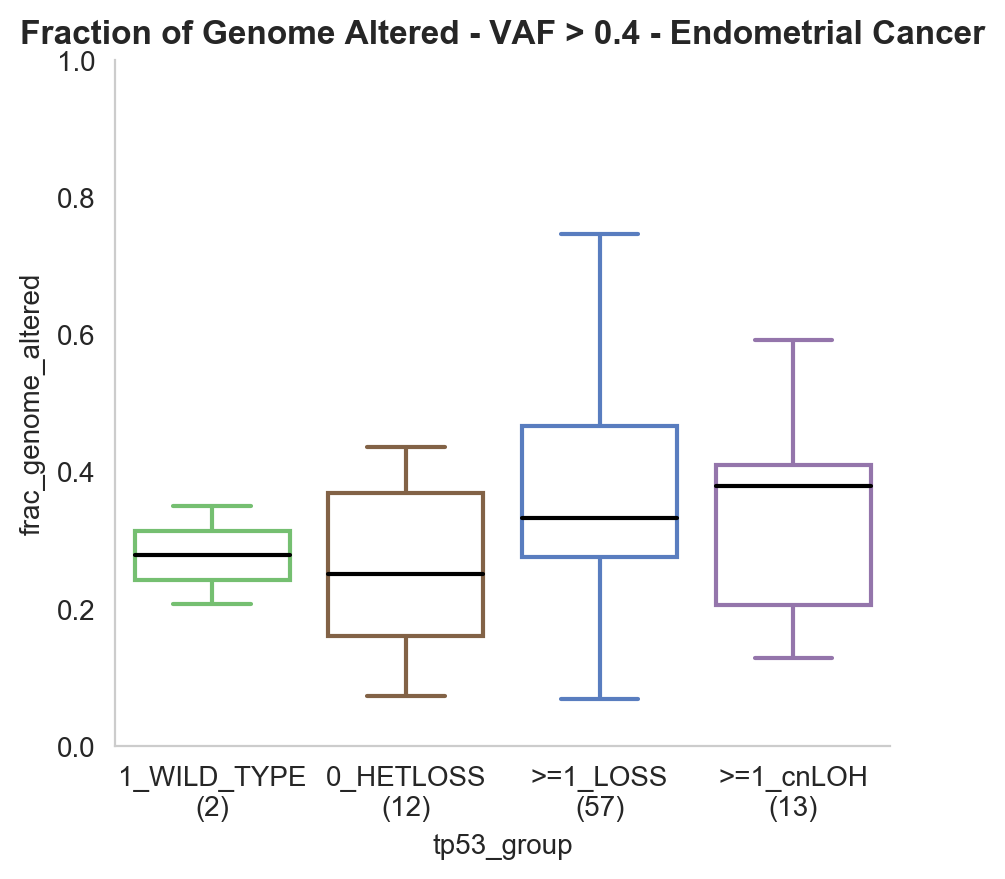

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,2,0.2785
2,0_HETLOSS,12,0.2515
3,,Statistics,p-value
4,,0.547723,0.583882


In [76]:
master_high = master_ccf[(master_ccf['vaf_group'] == 'high') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_high,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - VAF > {} - {}'.format(thr_vaf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_high,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

### CCF Analysis

#### No CCF Cut

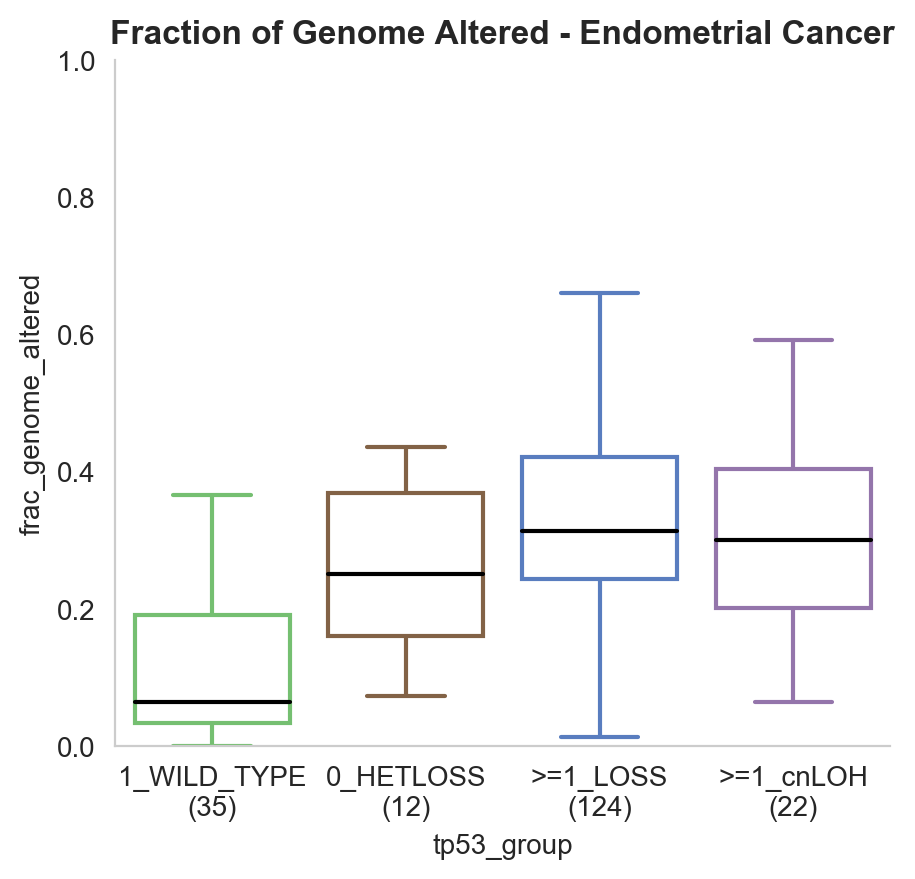

,0,1,2
0,,size,frac_genome_altered
1,0_HETLOSS,12,0.2515
2,1_WILD_TYPE,35,0.065
3,,Statistics,p-value
4,,2.85451,0.00431036


In [77]:
fig, ax = boxplot_sampletype(df=master_ccf,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_ccf,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['0_HETLOSS', '1_WILD_TYPE'])

#### Low CCF

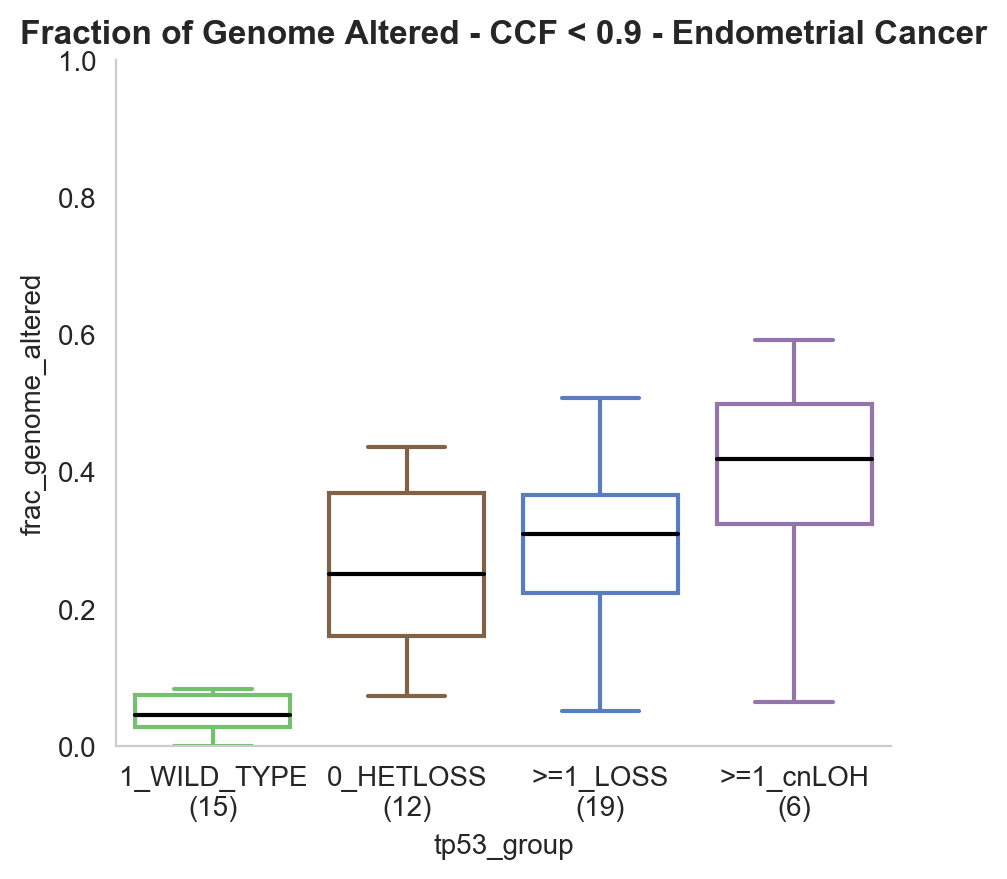

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,15,0.046
2,0_HETLOSS,12,0.2515
3,,Statistics,p-value
4,,-3.80601,0.000141227


In [78]:
master_low = master_ccf[(master_ccf['ccf_group'] == 'low') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_low,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - CCF < {} - {}'.format(thr_ccf_1,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_low,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### Medium CCF

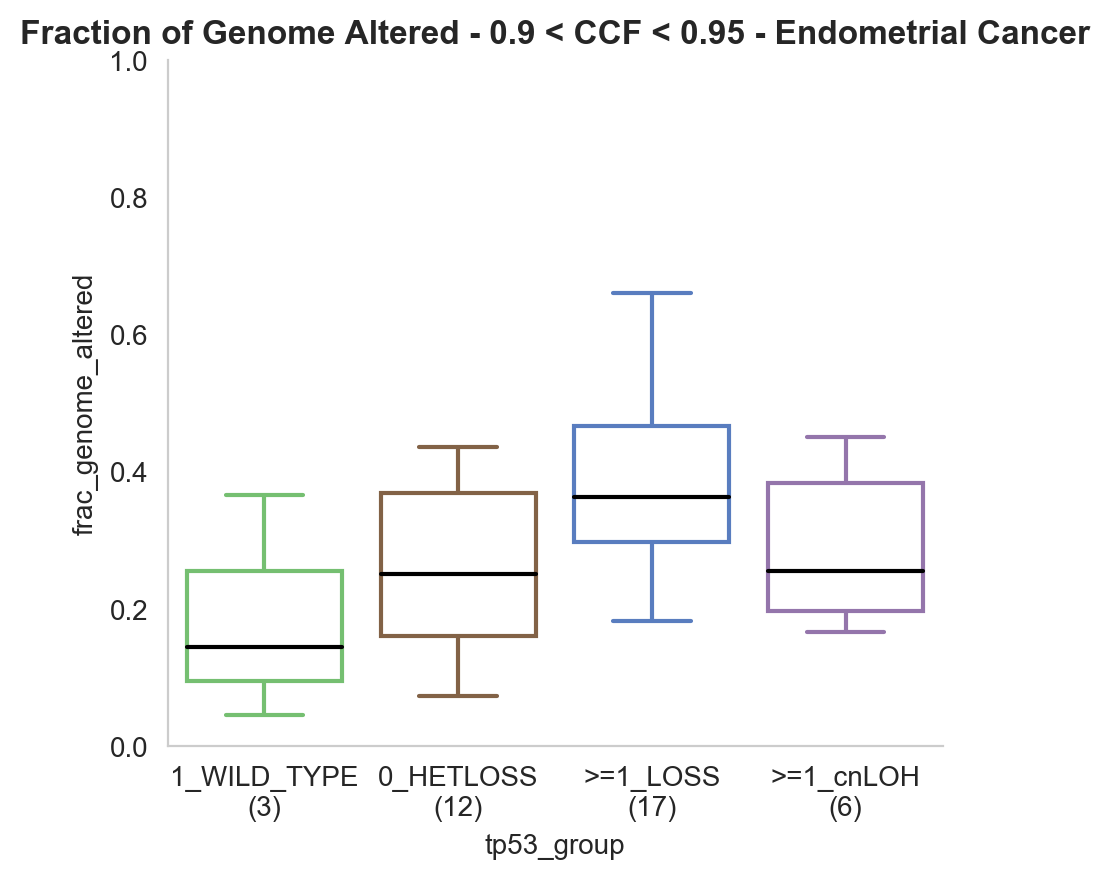

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,3,0.145
2,0_HETLOSS,12,0.2515
3,,Statistics,p-value
4,,-0.866025,0.386476


In [79]:
master_med = master_ccf[(master_ccf['ccf_group'] == 'medium') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_med,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {} < CCF < {} - {}'.format(thr_ccf_1,thr_ccf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_med,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### High CCF

In [ ]:
master_high = master_ccf[(master_ccf['ccf_group'] == 'high') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_high,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - CCF > {} - {}'.format(thr_ccf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_high,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

### Splitting on the different level of CCF / VAF

In [ ]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='vaf_group',
                  palette={'low': tab10[0] , 'medium': tab10[1], 'high':tab10[2]},
                  order=['low', 'medium', 'high'],
                  metrics='frac_genome_altered',
                  figsize=(3,10),
                  title='Fraction of Genome Altered - VAF levels - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_hotspot,
               group='vaf_group',
               metrics='frac_genome_altered',
               group_list=['low', 'medium'])

In [ ]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='ccf_group',
                  palette={'low': tab10[0] , 'medium': tab10[1], 'high':tab10[2]},
                  order=['low', 'medium', 'high'],
                  metrics='frac_genome_altered',
                  figsize=(3,10),
                  title='Fraction of Genome Altered - CCF levels - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_hotspot,
               group='ccf_group',
               metrics='frac_genome_altered',
               group_list=['low', 'medium'])

## Clinical Correlates

### Age

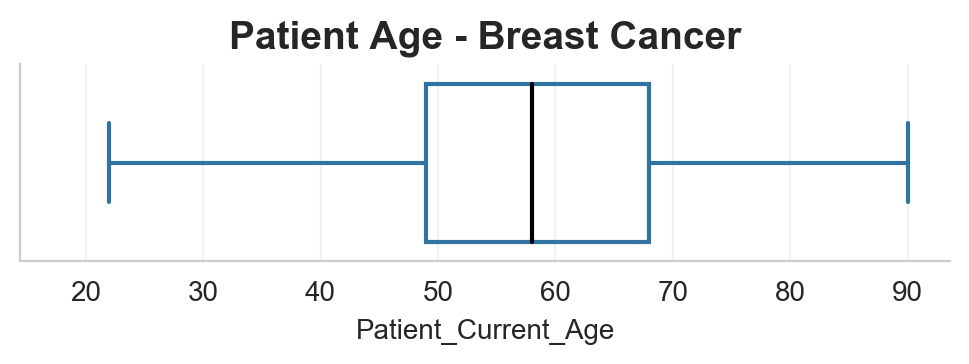

In [78]:
#fig=plt.figure(figsize=(10,3))
ax = plt.subplot2grid(shape=(4,1), loc=(0,0), colspan=1)

sns.boxplot(x='Patient_Current_Age',data=master_no_wgd_cancer, ax=ax).set_title('Patient Age - {}'.format(cancer), weight='bold', fontsize=14)


style(ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#### TP53 Residual Groups

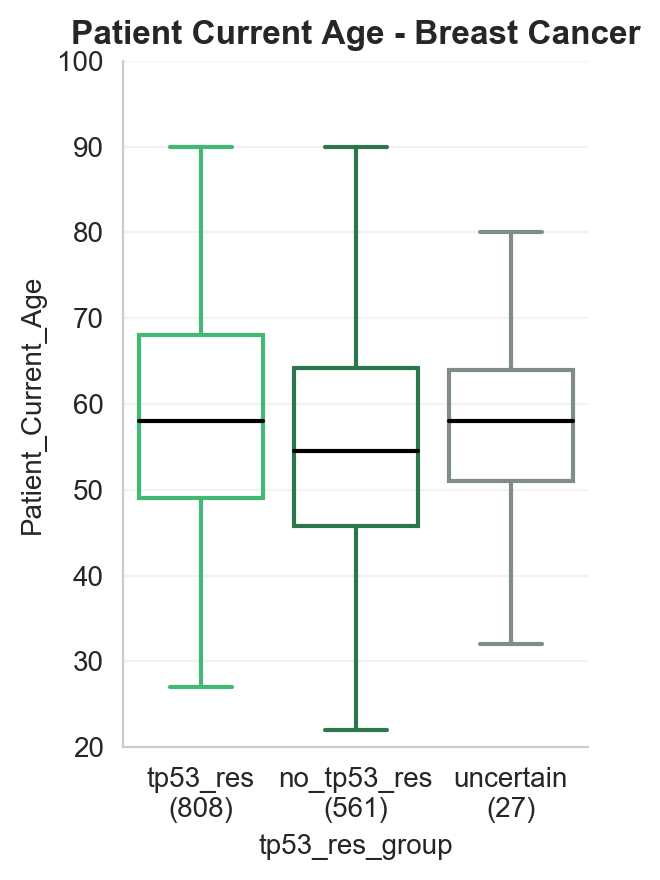

,0,1,2
0,,size,Patient_Current_Age
1,tp53_res,808,58
2,no_tp53_res,561,54.5
3,,Statistics,p-value
4,,4.33976,1.42636e-05


In [79]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_res_group',
                  palette=palette_res,
                  order=res_group_list,
                  metrics='Patient_Current_Age',
                  figsize=(3,10),
                  title='Patient Current Age - {}'.format(cancer),
                  xlim=[20,100])
plt.show()

get_statistics(df=master_no_wgd_cancer,
               group='tp53_res_group',
               metrics='Patient_Current_Age',
               group_list=['tp53_res', 'no_tp53_res'])

#### TP53 Subgroups

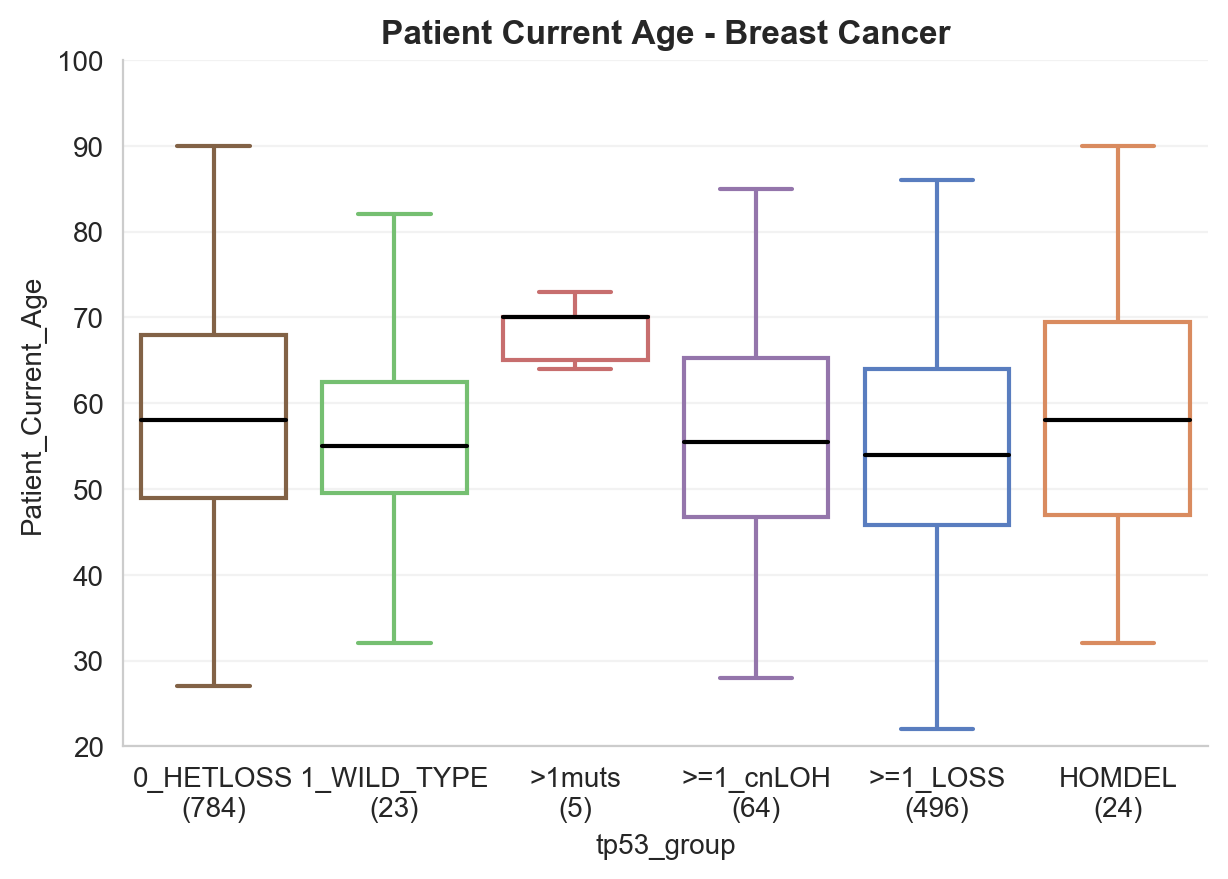

,0,1,2
0,,size,Patient_Current_Age
1,1_WILD_TYPE,23,55
2,>=1_cnLOH,64,55.5
3,,Statistics,p-value
4,,0.341683,0.732589


In [80]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='Patient_Current_Age',
                  figsize=(7,10),
                  title='Patient Current Age - {}'.format(cancer),
                  xlim=[20,100])
plt.show()

get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='Patient_Current_Age',
               group_list=['1_WILD_TYPE', '>=1_cnLOH'])

### Sex

,count
Sex,
Female,2307
Male,10


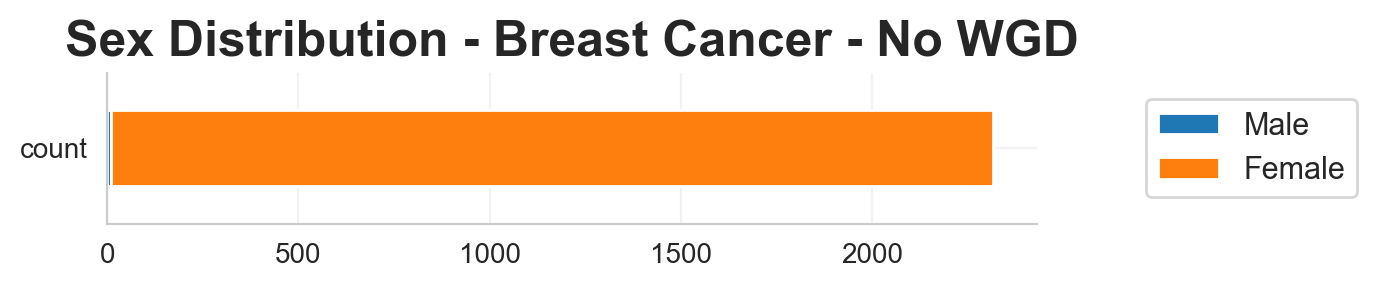

In [81]:
h = get_groupby(master_no_wgd_cancer,'Sex', 'count').sort_values(by='count', ascending=False)
display(h)

h = h.T
h = h[['Male', 'Female']]
fig = plt.figure(figsize=(6,1))
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax)
ax.legend(['Male', 'Female'],loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=11)
ax.set_title('Sex Distribution - {} - No WGD'.format(cancer), weight='bold', fontsize=18)

plt.show()

### Survival Analysis

In [82]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [83]:
data = master_no_wgd_cancer.dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)

data = data[['tp53_group', 'tp53_res_group', 'Overall Survival Status 0/1', 'Overall_Survival_Months']]

ix1 = data['tp53_res_group'] == 'tp53_res'
ix2 = data['tp53_res_group'] == 'no_tp53_res'

T_exp, E_exp = data.loc[ix1, 'Overall_Survival_Months'], data.loc[ix1, 'Overall Survival Status 0/1']
T_con, E_con = data.loc[ix2, 'Overall_Survival_Months'], data.loc[ix2, 'Overall Survival Status 0/1']

results = logrank_test(T_exp, T_con, event_observed_A=E_exp, event_observed_B=E_con)
results.print_summary()

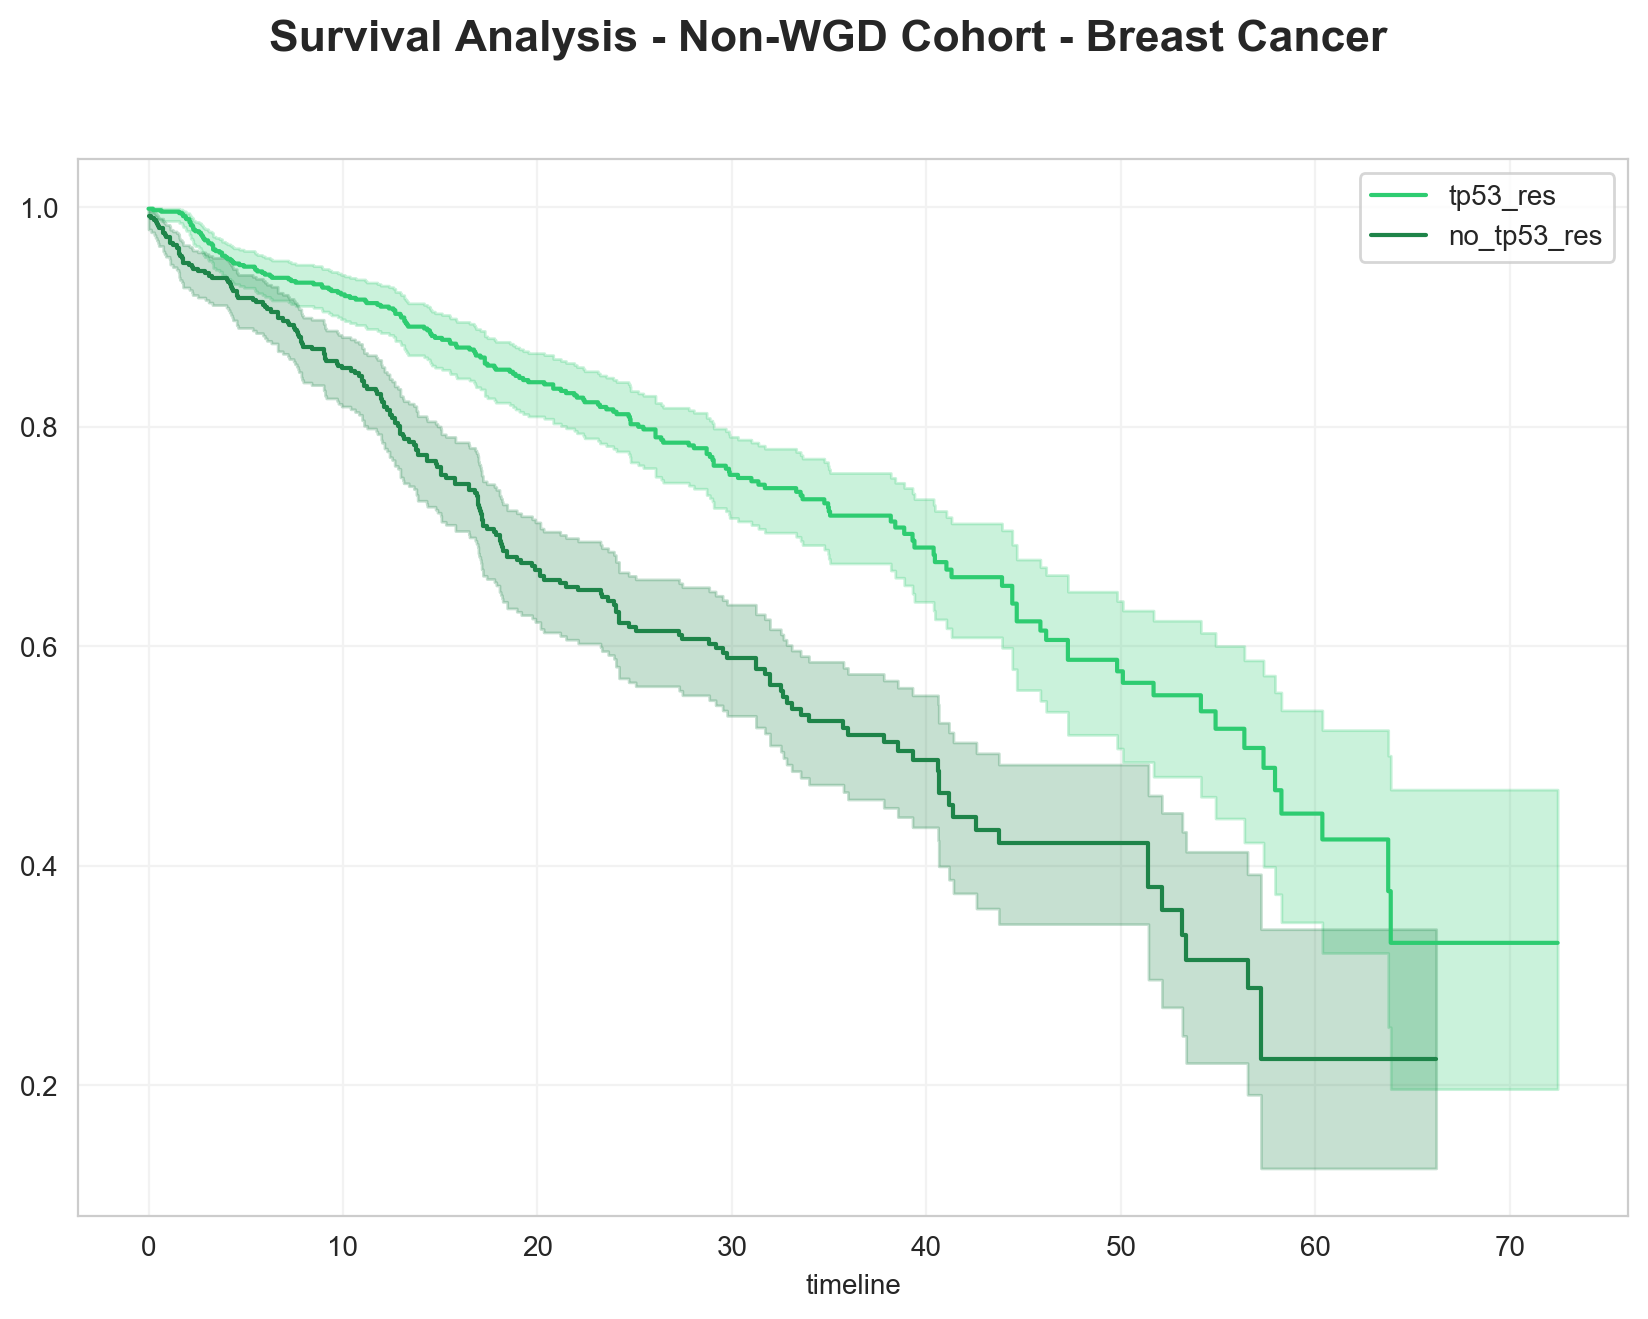

In [91]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
fig.suptitle('Survival Analysis - Non-WGD Cohort - {}'.format(cancer), fontsize=16, weight='bold')
kmf = KaplanMeierFitter()

for group,i in zip(res_group_list[:2], range(len(res_group_list[:2]))):
    data = master_no_wgd_cancer[master_no_wgd_cancer['tp53_res_group'] == group].dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
    data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)
    kmf.fit(np.array(data['Overall_Survival_Months']), event_observed=np.array(data['Overall Survival Status 0/1']),  label= group)
    kmf.plot_survival_function(color = res_palette_list[i], ax=ax)
plt.show()

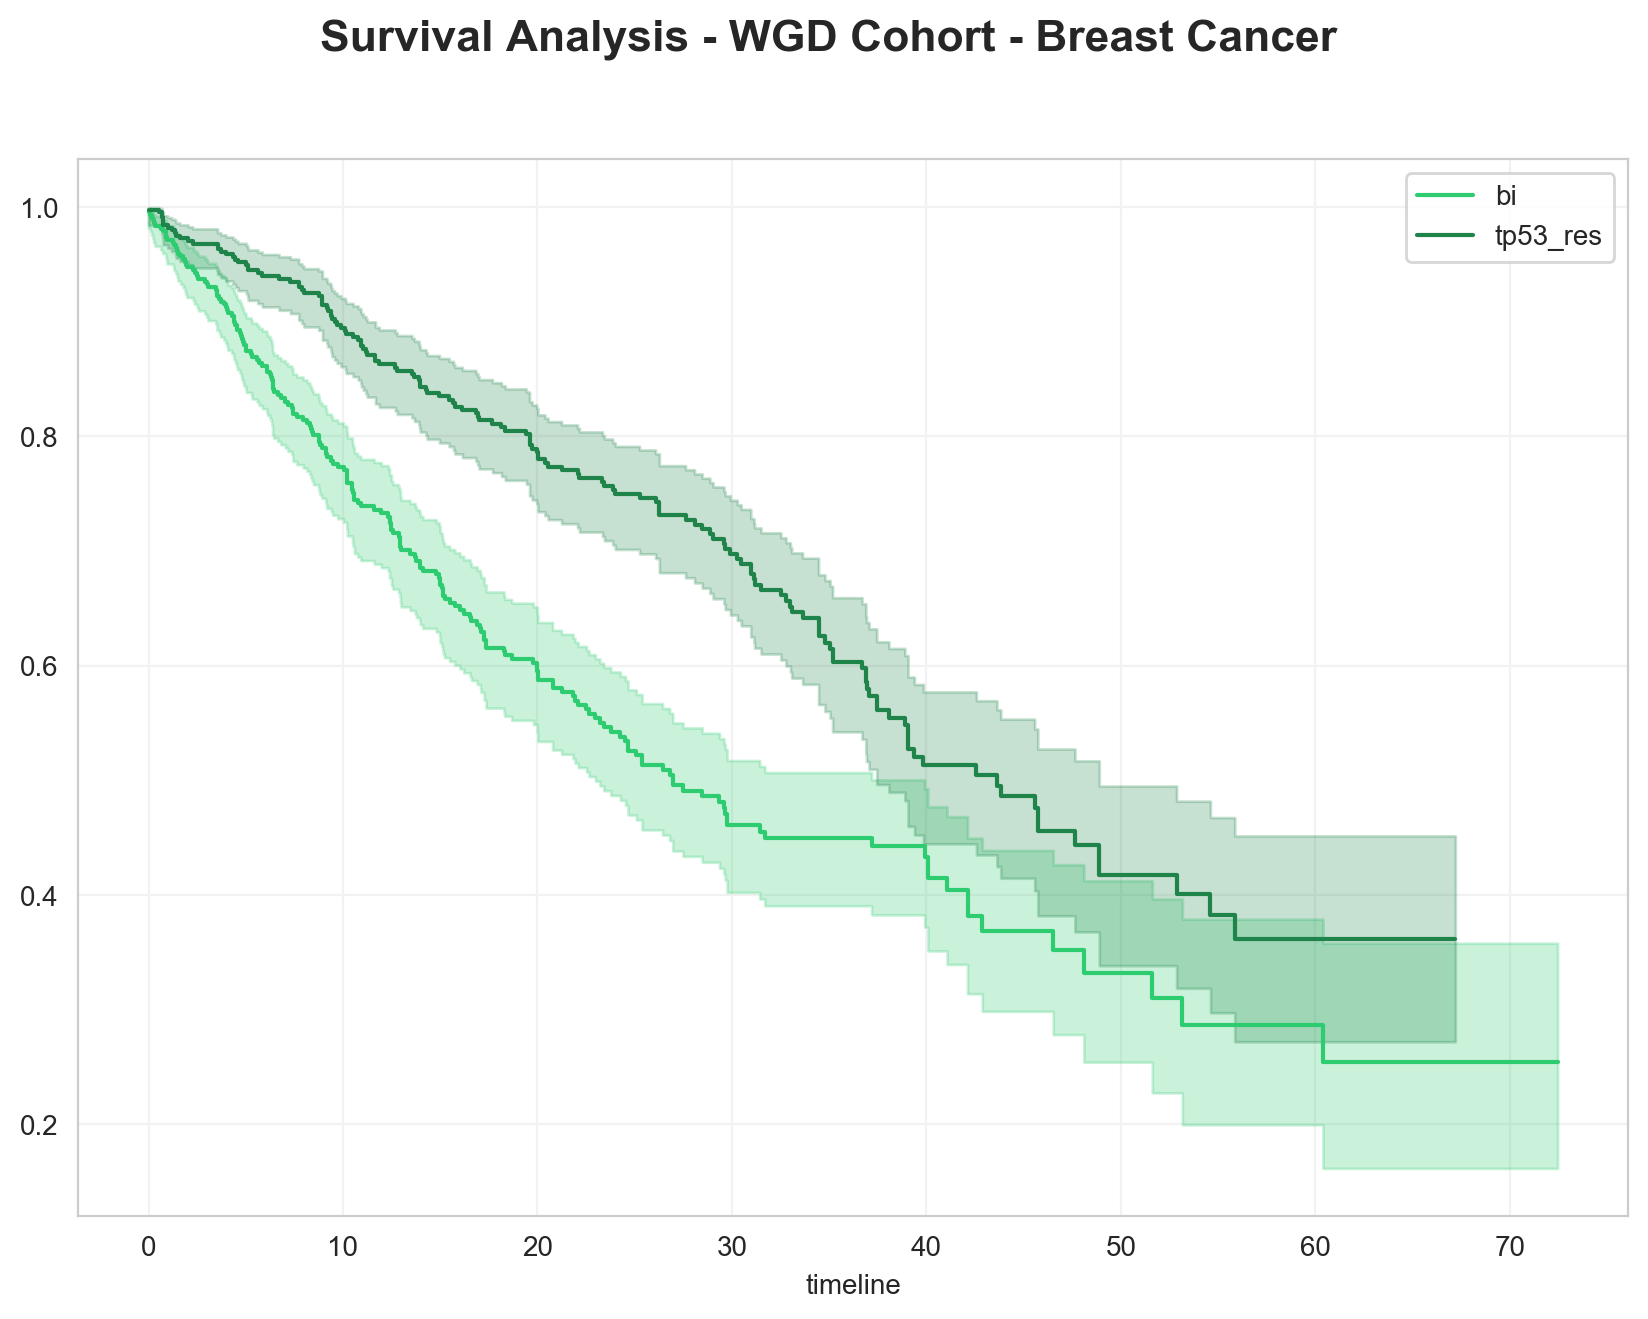

In [89]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
fig.suptitle('Survival Analysis - WGD Cohort - {}'.format(cancer), fontsize=16, weight='bold')
kmf = KaplanMeierFitter()


for group,i in zip(['bi', 'tp53_res'], range(2)):
    data = master_wgd_cancer[master_wgd_cancer['prewgd_tp53_group_1'] == group].dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
    data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)
    kmf.fit(np.array(data['Overall_Survival_Months']), event_observed=np.array(data['Overall Survival Status 0/1']),  label= group)
    kmf.plot_survival_function(color = res_palette_list[i], ax=ax)
plt.show()

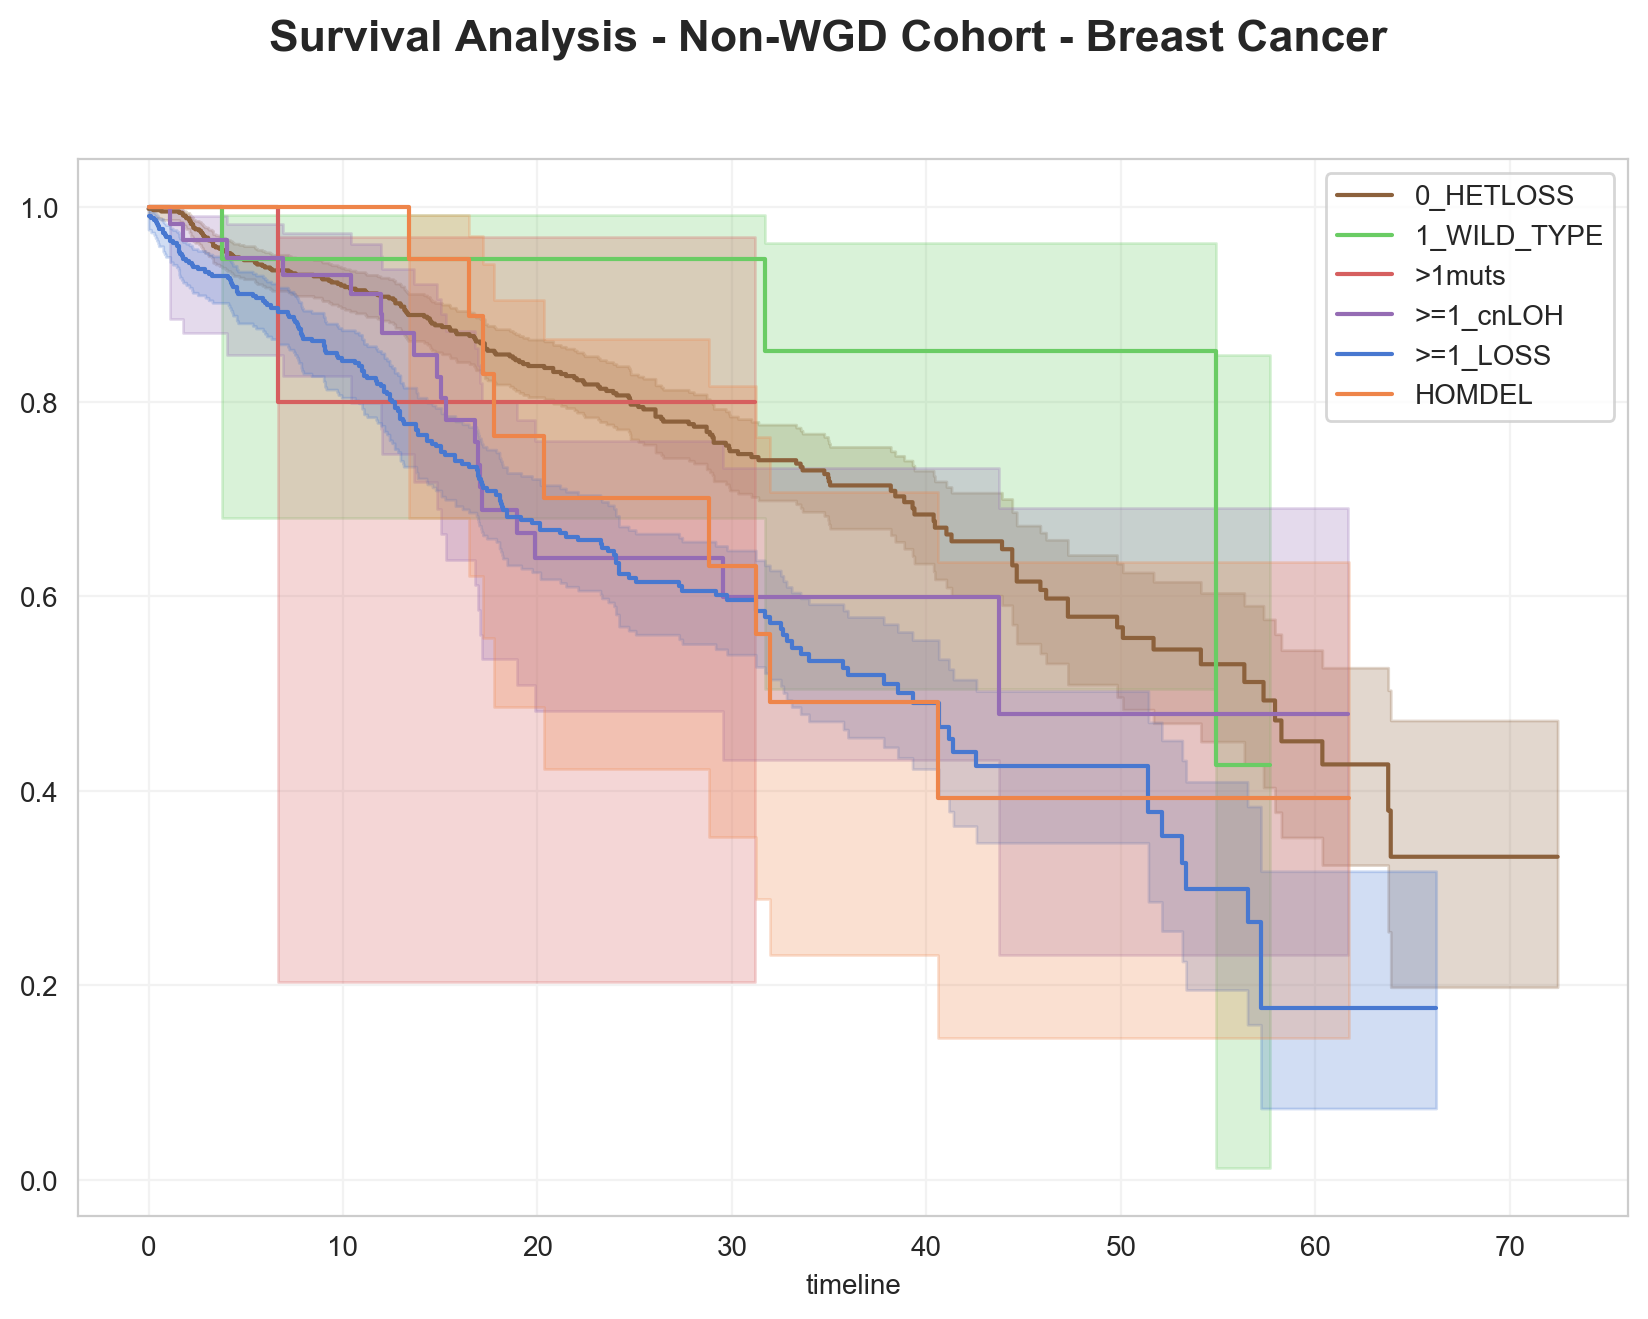

In [90]:
from lifelines import KaplanMeierFitter

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
fig.suptitle('Survival Analysis - Non-WGD Cohort - {}'.format(cancer), fontsize=16, weight='bold')
kmf = KaplanMeierFitter()

for group,i in zip(group_list, range(len(group_list))):
    data = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == group].dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
    data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)
    kmf.fit(np.array(data['Overall_Survival_Months']), event_observed=np.array(data['Overall Survival Status 0/1']),  label= group)
    kmf.plot_survival_function(color = palette_list[i], ax=ax)
plt.show()

#### High CCF

In [93]:
master_high = master_ccf[(master_ccf['ccf_group'] == 'high') | (master_ccf['tp53_group'] == '0_HETLOSS')]

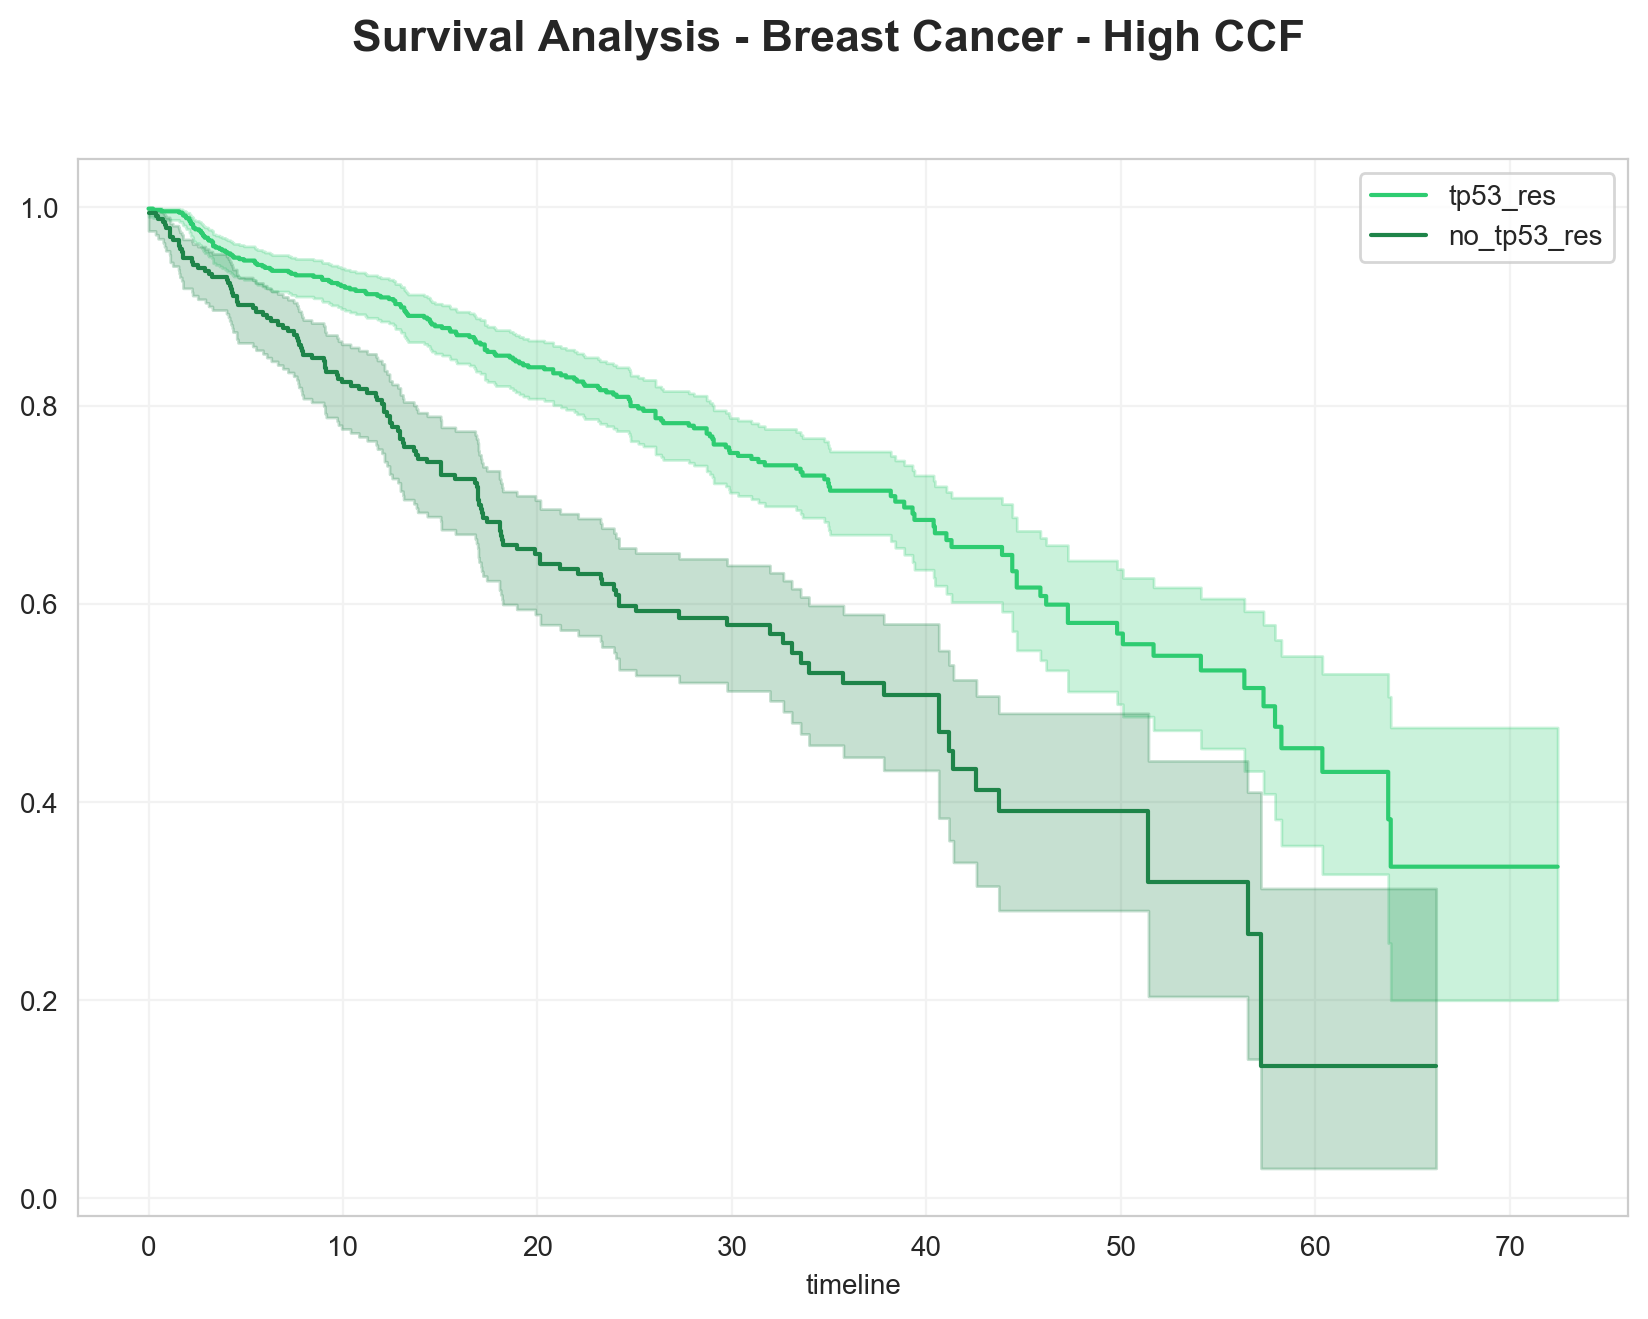

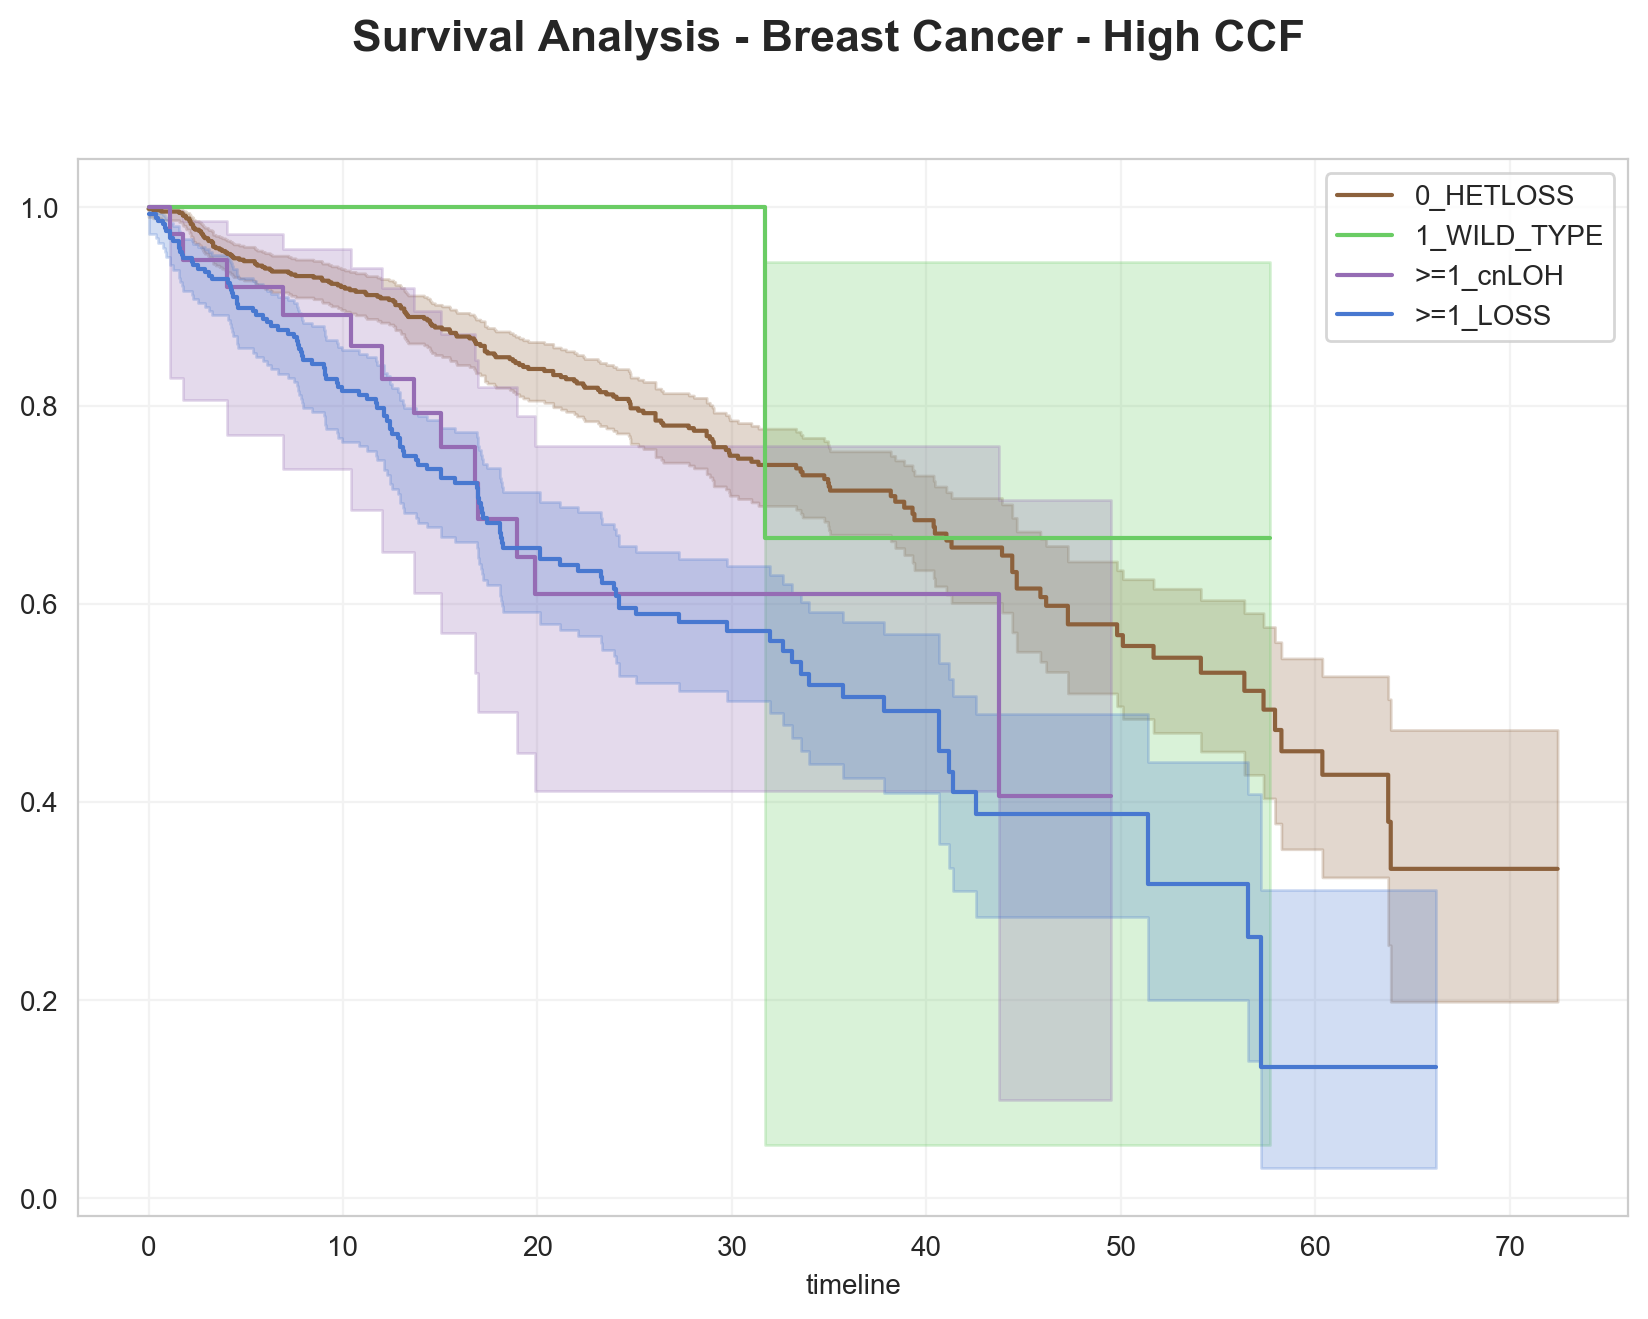

In [94]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
fig.suptitle('Survival Analysis - {} - High CCF'.format(cancer), fontsize=16, weight='bold')
kmf = KaplanMeierFitter()

for group,i in zip(res_group_list, range(len(res_group_list))):
    data = master_high[master_high['tp53_res_group'] == group].dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
    try:
        data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)
        kmf.fit(np.array(data['Overall_Survival_Months']), event_observed=np.array(data['Overall Survival Status 0/1']),  label= group)
        kmf.plot_survival_function(color = res_palette_list[i], ax=ax)
    except: pass
plt.show()


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
fig.suptitle('Survival Analysis - {} - High CCF'.format(cancer), fontsize=16, weight='bold')
kmf = KaplanMeierFitter()

for group,i in zip(group_list, range(len(group_list))):
    data = master_high[master_high['tp53_group'] == group].dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
    try:
        data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)
        kmf.fit(np.array(data['Overall_Survival_Months']), event_observed=np.array(data['Overall Survival Status 0/1']),  label= group)
        kmf.plot_survival_function(color = palette_list[i], ax=ax)
    except: pass
plt.show()